<a href="https://colab.research.google.com/github/Leina400/Academic-Project/blob/main/%20Academic-Project/ComputerVision/Section1/Copie_de_0_SIFT_BoW_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>0: SIFT, BoW and SVM</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.



# During these first practical works, we are going to prepare the development of an initial image classification model: an handcrafted BoW model + SVM classifier.
# The goal is to produce an algorithm that is able to classify images from the dataset 15-Scenes. This dataset contains 4485 images belonging to 15 scenes categories (e.g. kitchen, bedroom, street, etc.)

# Let's start by downloading the datasets and some useful functions

In [ ]:
!rm -rf data

!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/TP1-2-data.zip
!unzip TP1-2-data.zip

!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/1-ab/tools.py

--2025-09-27 11:11:22--  https://github.com/rdfia/rdfia.github.io/raw/master/data/TP1-2-data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/TP1-2-data.zip [following]
--2025-09-27 11:11:23--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/TP1-2-data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86446976 (82M) [application/zip]
Saving to: ‘TP1-2-data.zip’

TP1-2-data.zip      100%[===================>]  82.44M   290MB/s    in 0.3s    

2025-09-27 11:11:24 (290 MB/s) - ‘TP1-2-data.zip’ saved [86446976/86446976]

Archive:  TP1-2-data

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
%run 'tools.py'
from os.path import join

data_path = "data"

## **<u>Part I:</u>** we will first extract SIFT (Scale-invariant feature transform) which are local visual descriptors and thus can encode a small patch of image.

## **<u>Part II:</u>** Then, we’ll explore some archetype descriptors that represent recurring patterns to build a **visual dictionnary**.

## **<u>Part III:</u>** Then, we’ll aggregate the SIFTs of each image with a BoW (Bag of Words) method that express in a compact way an image.

## **<u>Part IV:</u>** Finally, we’ll learn to classify each image, from its BoW representation by using a SVM (Support Vector Machine).

# Part I: SIFT

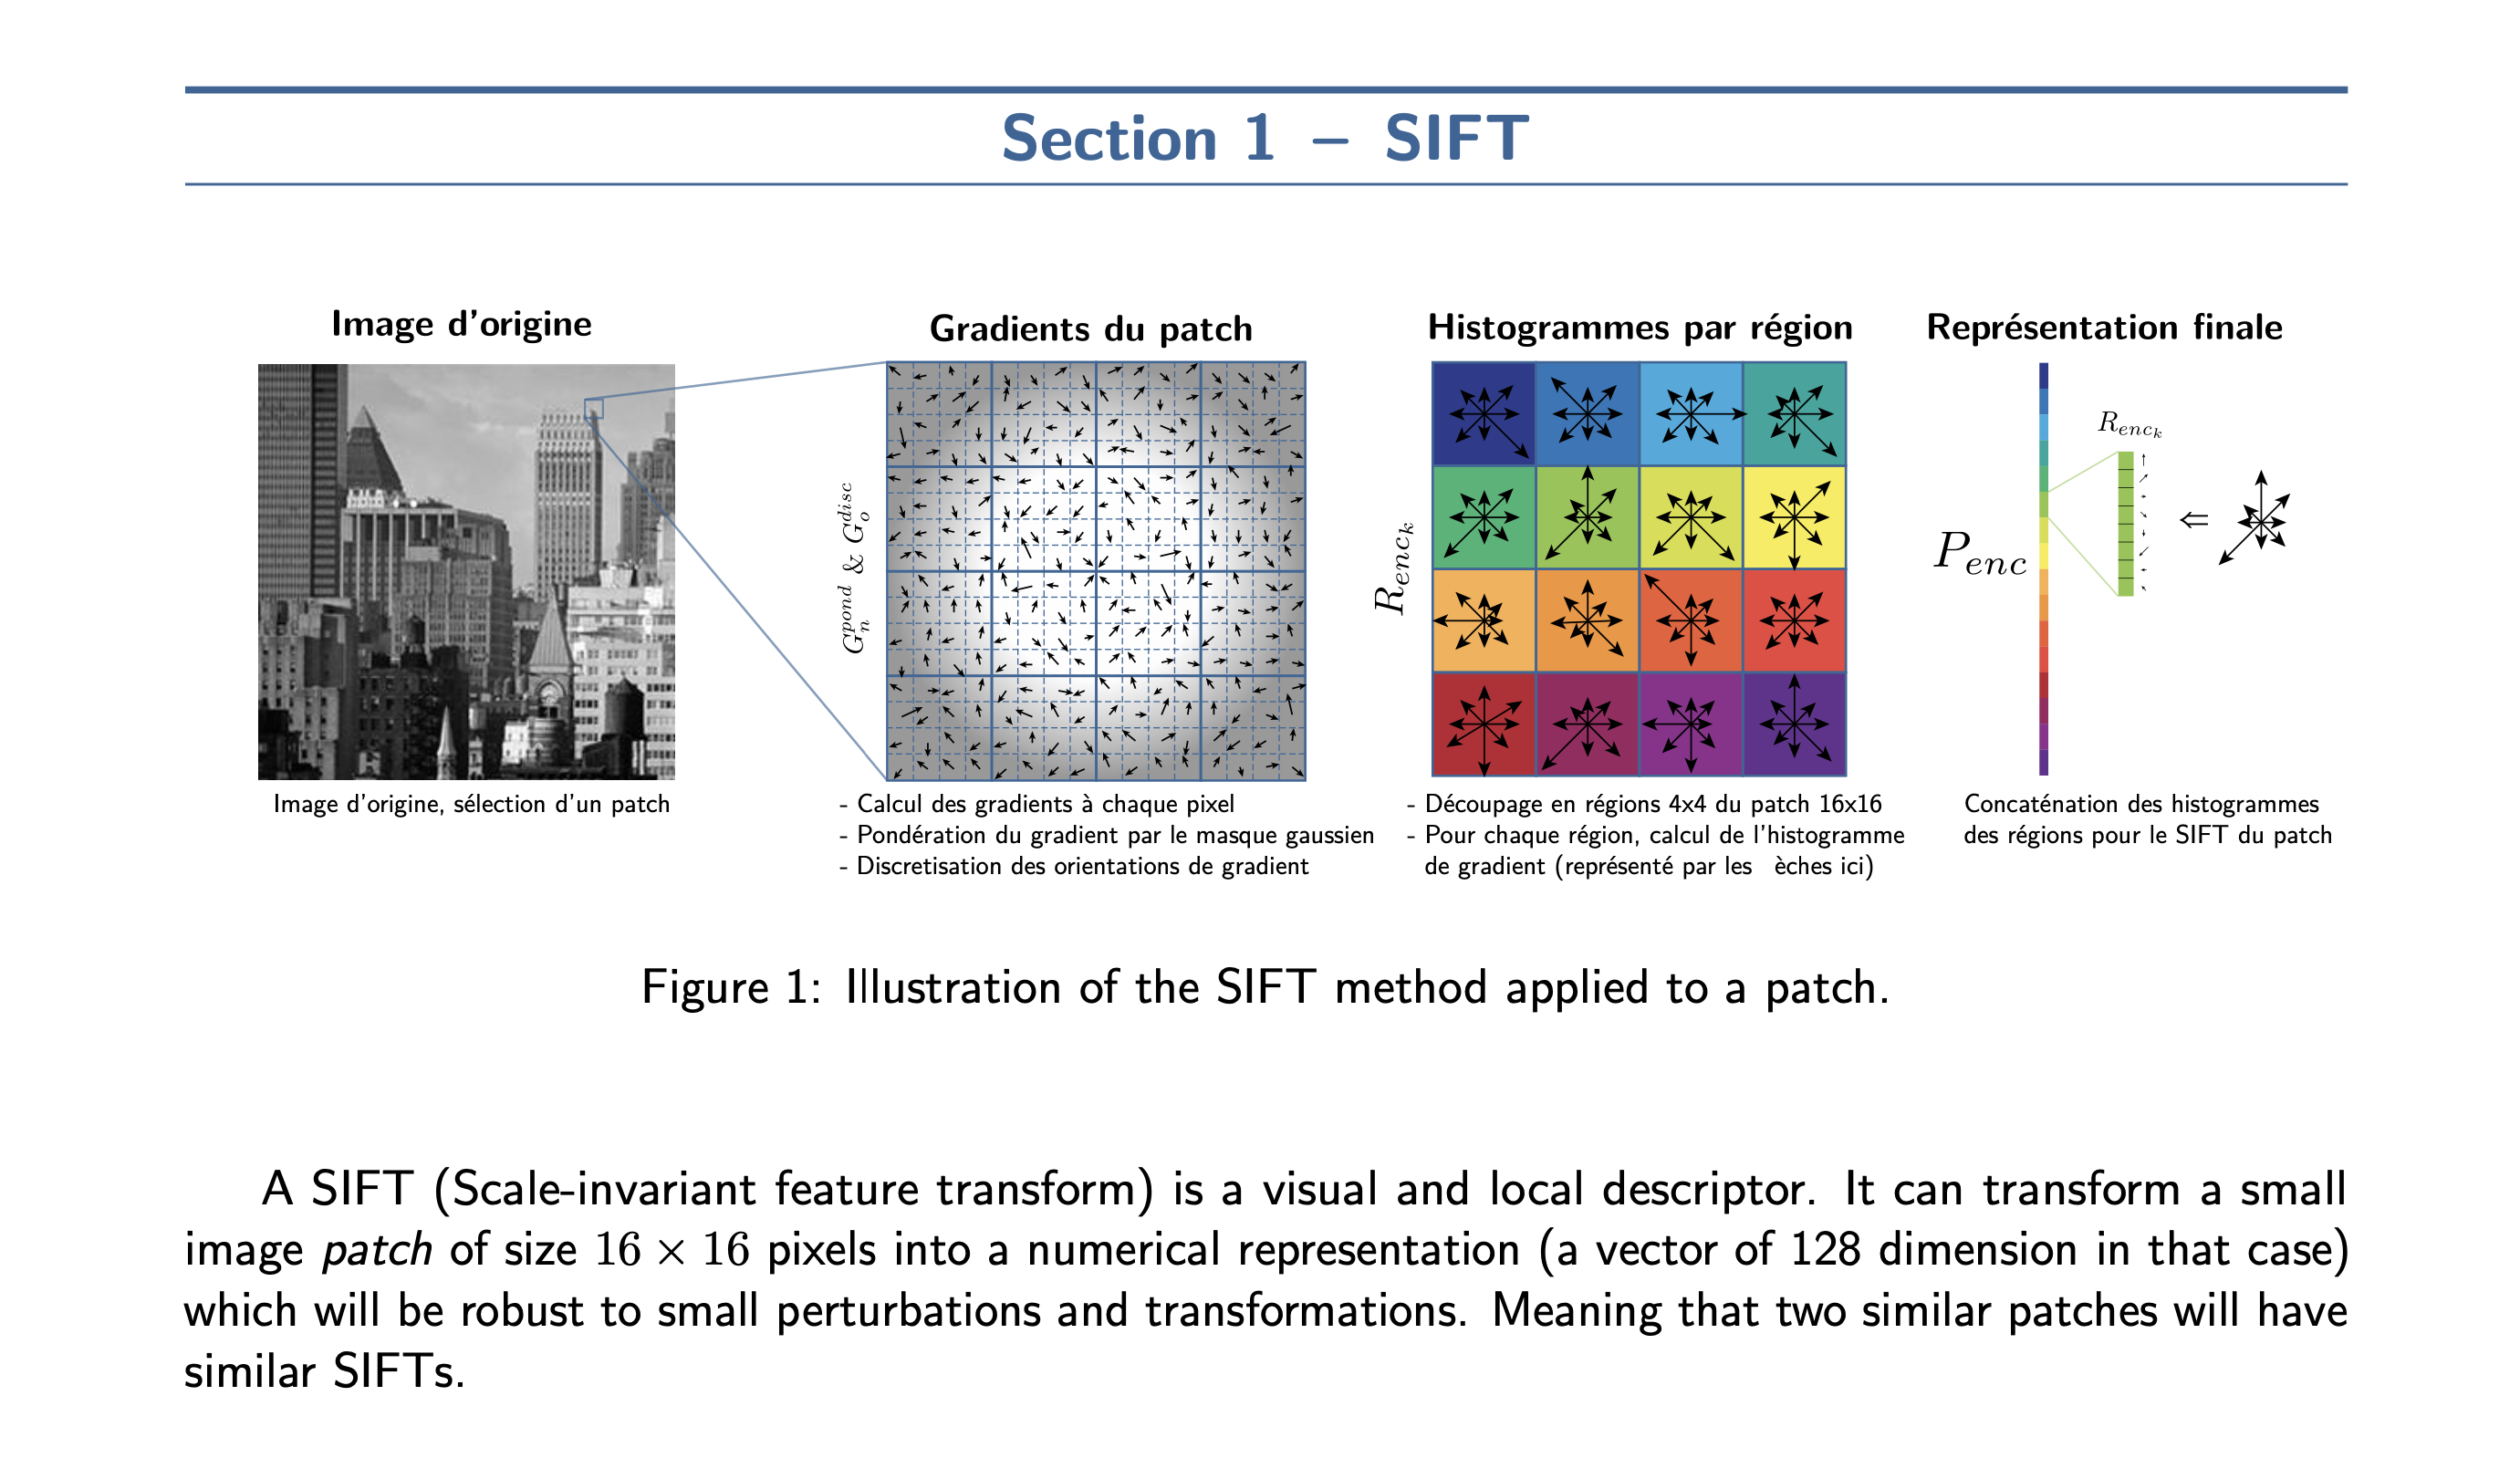

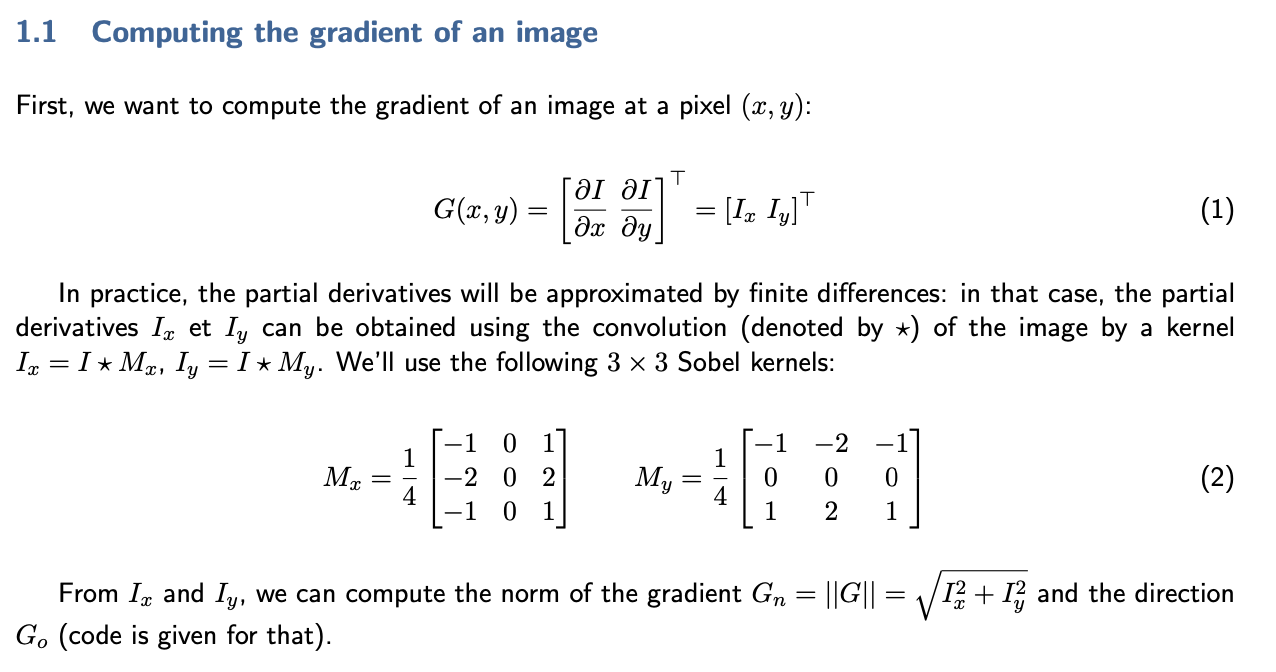

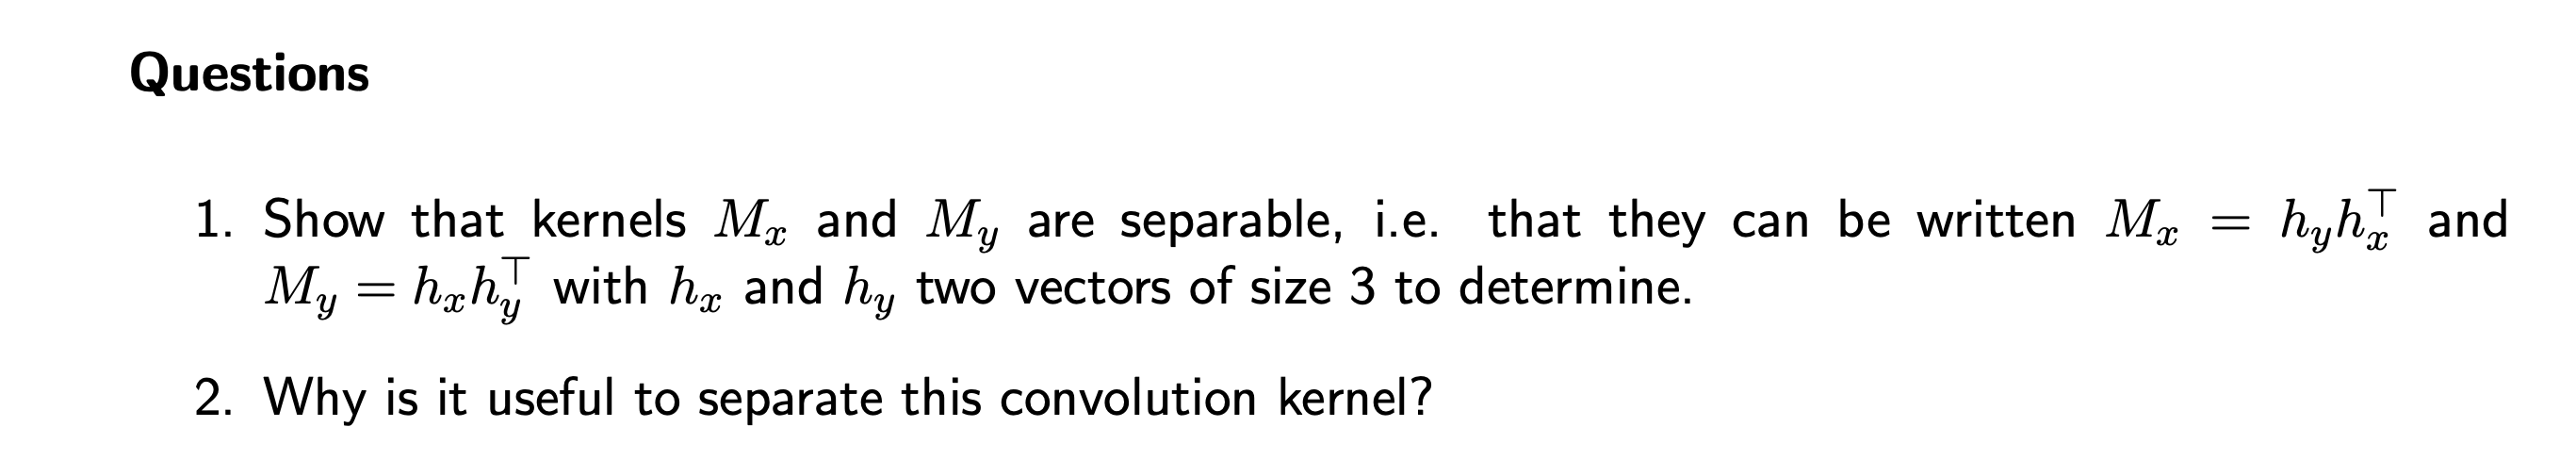

Question : pk ces matrices en particulier et pas d'autres ?

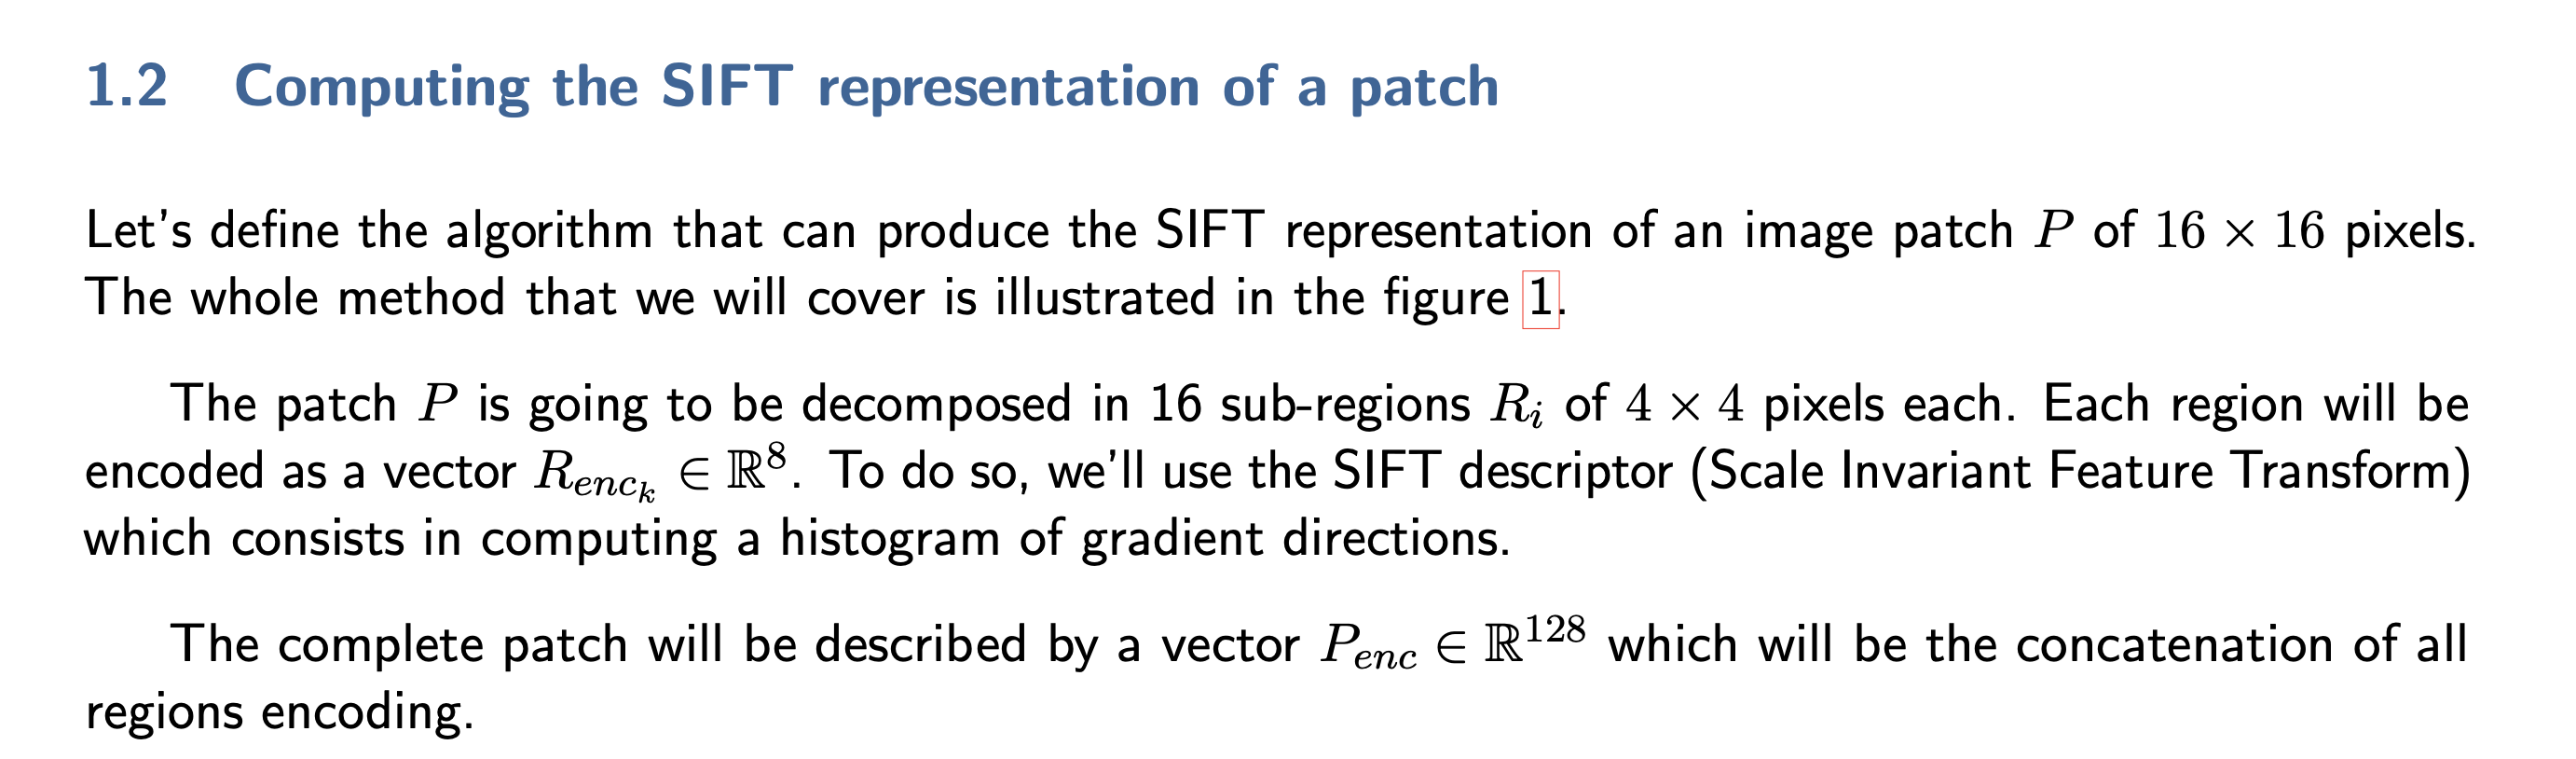

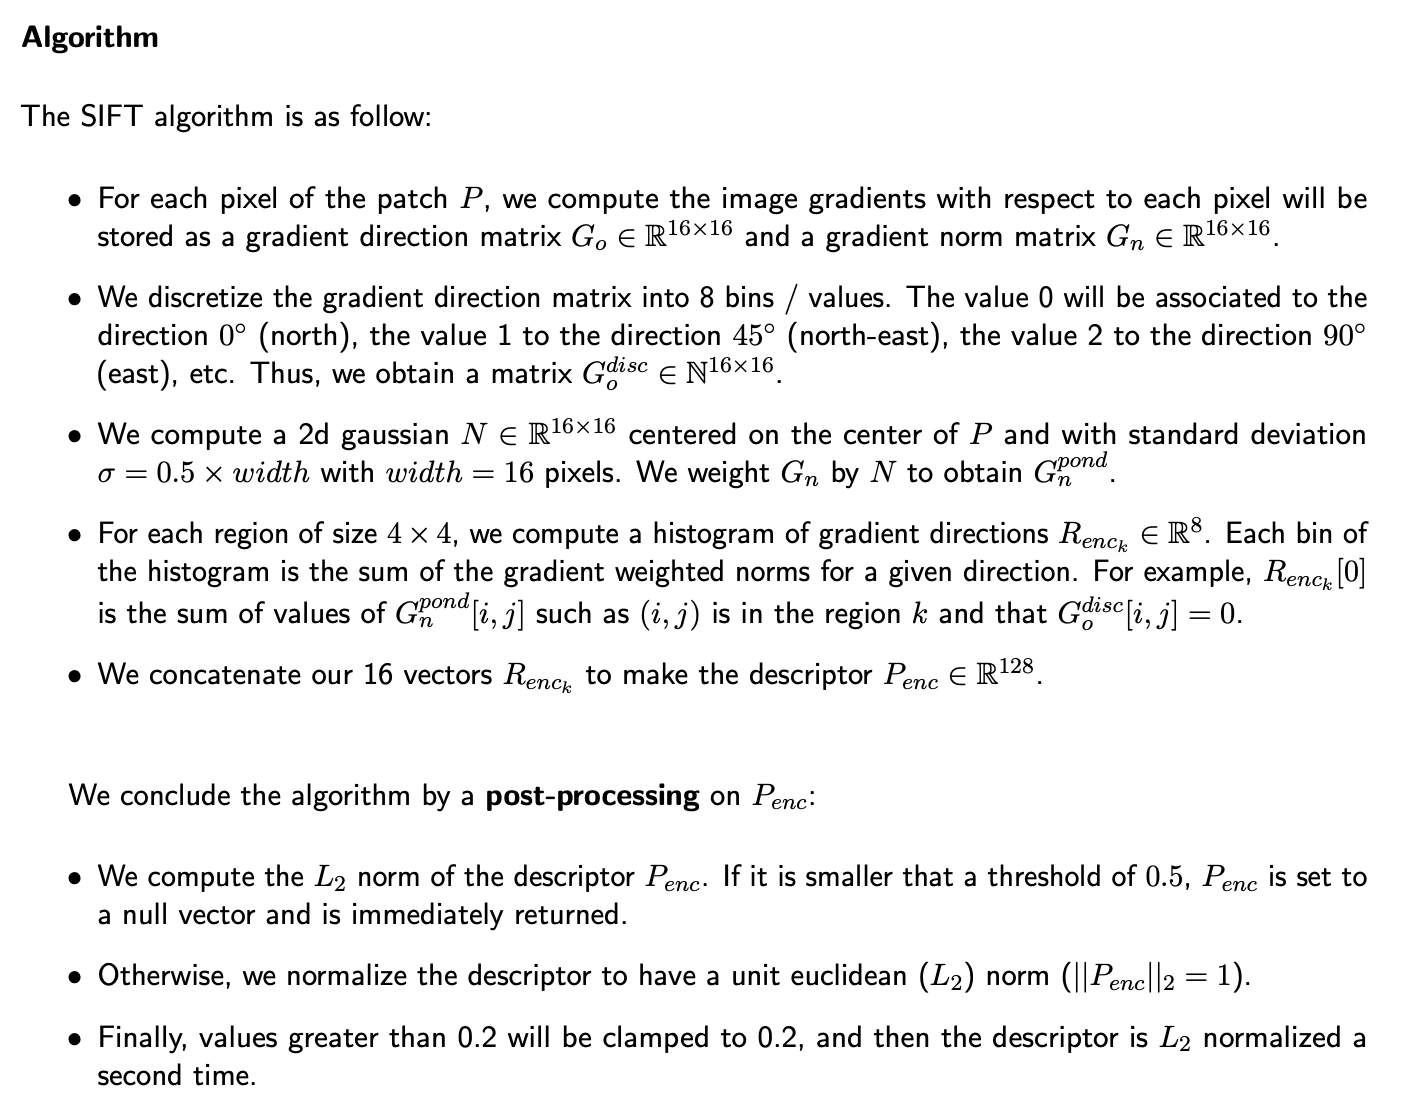

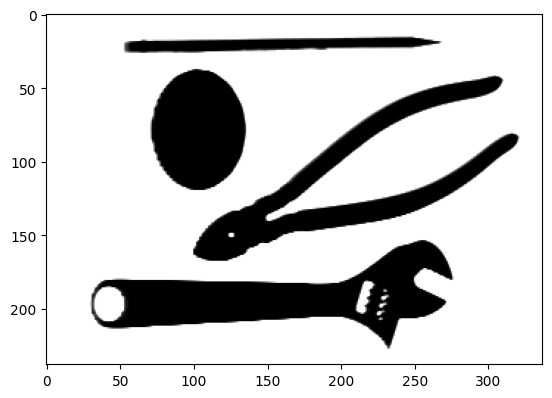

In [ ]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I, cmap='gray')

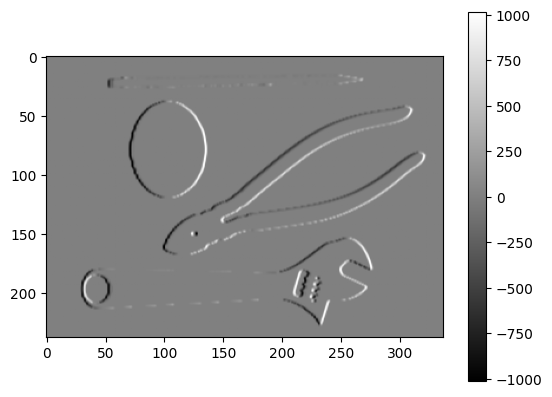

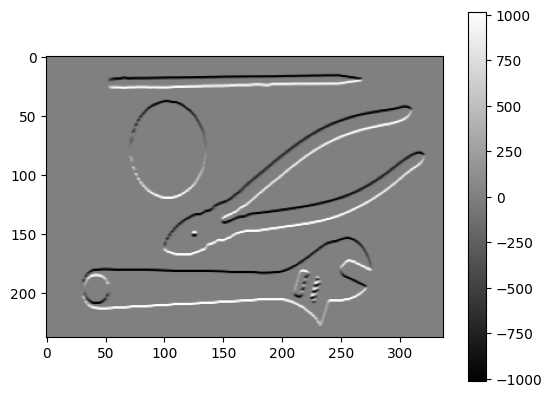

In [ ]:
def compute_grad(I):
    # hx et hy qu'on a calculé en haut
    hy = np.array([1, 2, 1])
    hx = np.array([-1, 0, 1])
    Ix = conv_separable(I, hx, hy)
    Iy = conv_separable(I, hy, hx)
    # Ix et Iy -> dérivé partielle dans la direction de x et direction de y
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
# met en évidence les bords horizontaux
plt.imshow(Ix, cmap="gray")
plt.colorbar()
plt.show()
# met en evidence les bords verticaux
plt.imshow(Iy, cmap="gray")
plt.colorbar()
plt.show()

# ca nous donne le contraste -> changement d'intensite, directions des gradients ??


In [ ]:
I

array([[254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       ...,
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.]])

In [ ]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    # norme des gradients
    Gn = np.sqrt(Ix**2 + Iy**2)
    # ?? matrice discrete
    Go = compute_grad_ori(Ix, Iy, Gn)
    return Gn, Go

# calcule de la norme du gradient des direction (Gn) et discrétisation des directions (G0)

In [ ]:
#?compute_grad_ori

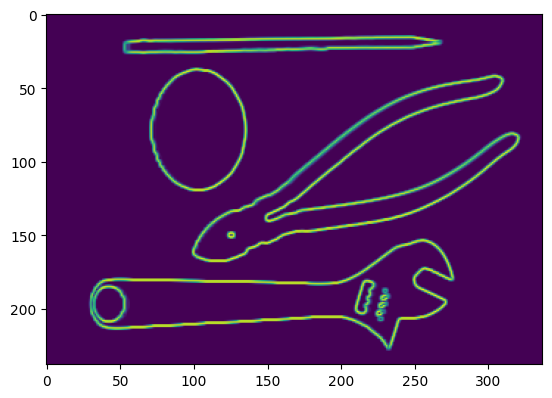

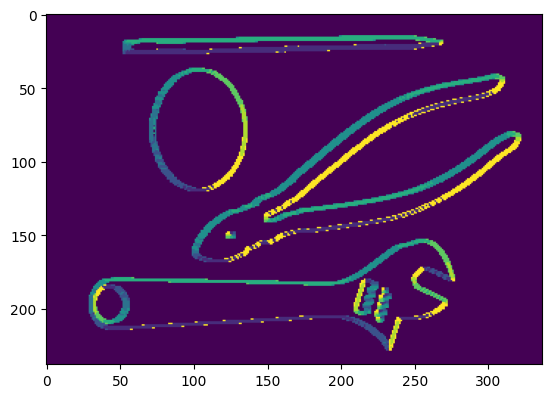

In [ ]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)#, cmap="gray")
plt.show()
plt.imshow(Go)#, cmap="gray")
plt.show()

In [ ]:
Gn.shape

(238, 337)

In [ ]:
?compute_sift_region

Object `compute_sift_region` not found.


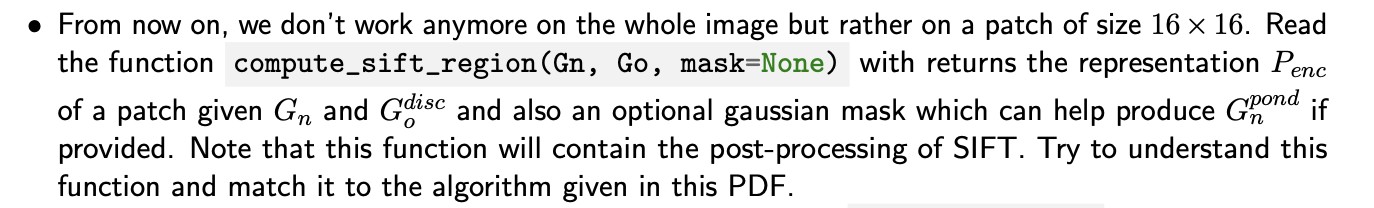

In [ ]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))

    for j in range(4):
        for i in range(4):
            if g_o[i,j] != -1:
                hist[g_o[i,j]] += g_n[i,j]
    return hist

    # cmt est obtenu G_n^pond


In [ ]:
# comprendre cette fonction

def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128))

    if mask is not None:
        Gn = Gn * mask

    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

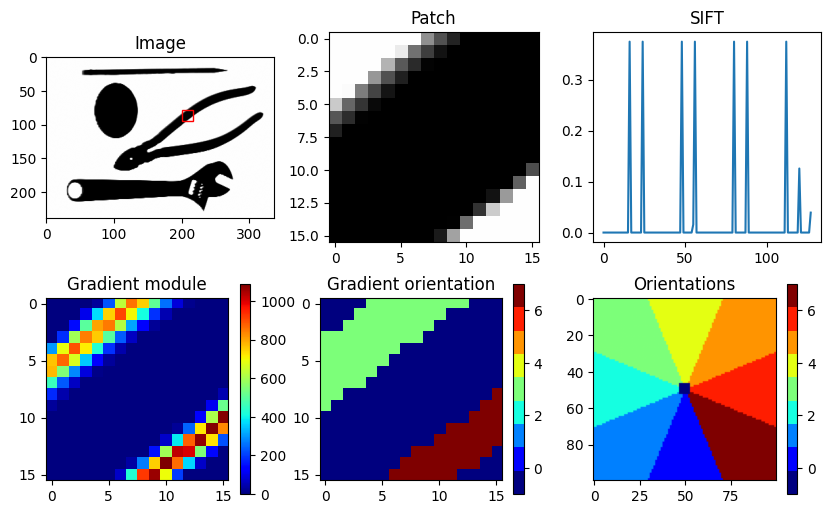

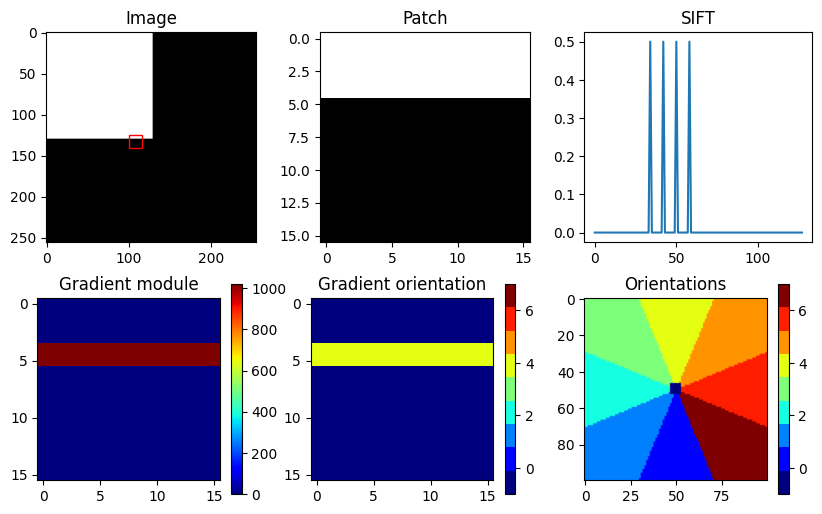

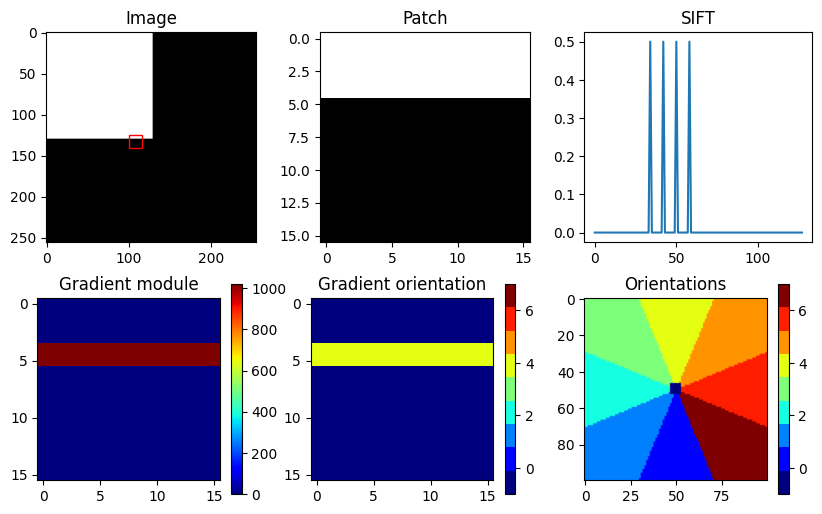

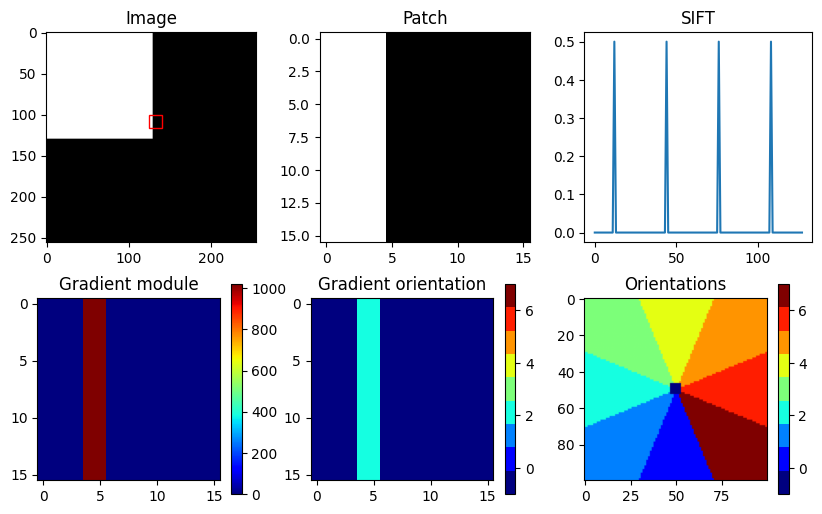

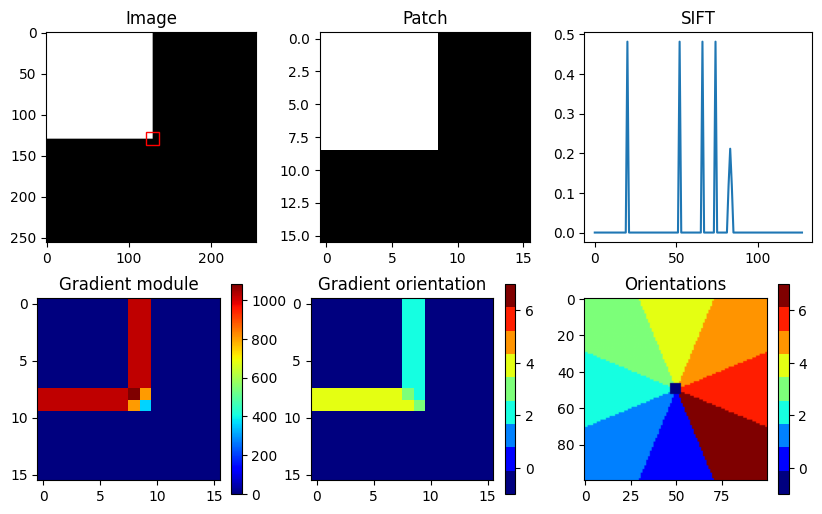

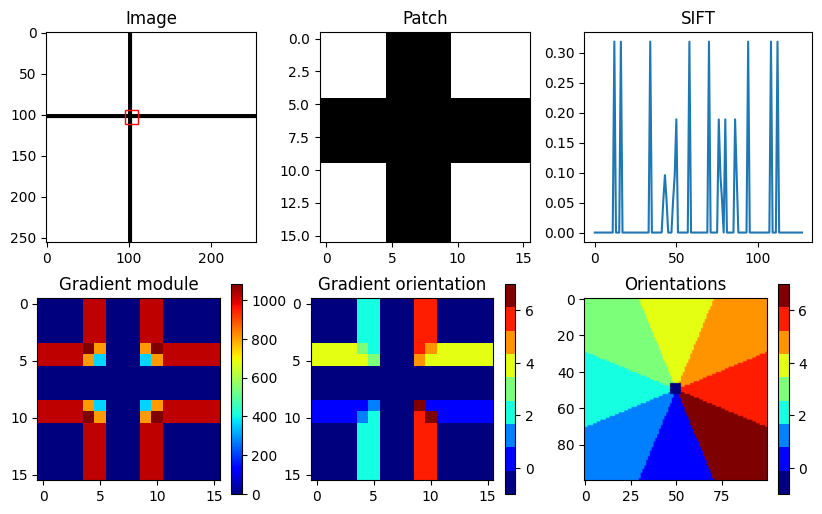

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.05344409, 0.09560369,
       0.18864812, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3181317 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.     

In [ ]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

# interpretation ??

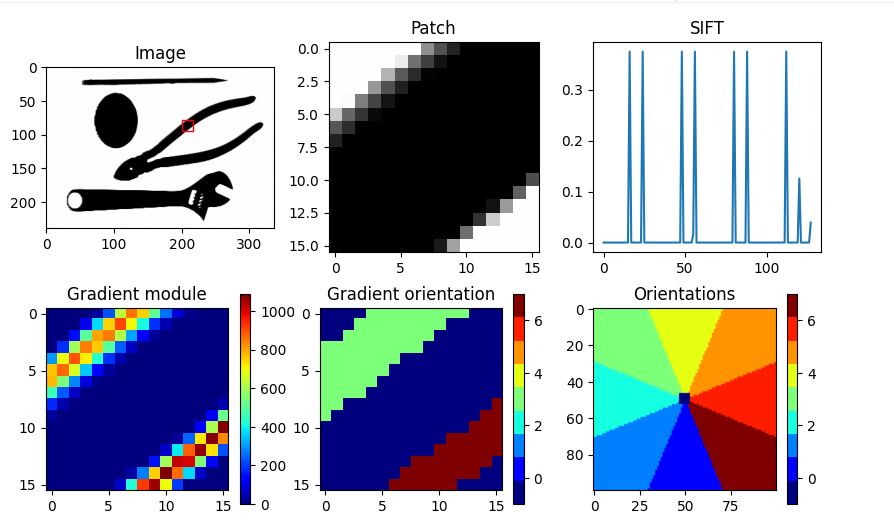

**Interpretation** :

* Image (à gauche)
  * On voit l’image globale des objets, avec un petit carré rouge qui indique le patch choisi (16×16 pixels). Ce patch est situé sur la pince, au niveau d’un bord oblique.

* Patch (au centre)
  * Extrait local : une transition en diagonale du blanc vers le noir. Visuellement, on reconnaît un bord oblique.

* SIFT (à droite)
  * Le vecteur de descripteur (128 dimensions) sous forme de graphique. On observe plusieurs pics très marqués → cela signifie que certaines directions de gradients dominent clairement. Ces pics correspondent aux orientations diagonales qui décrivent bien ce bord.

* Gradient module (ligne du bas à gauche) : Carte des intensités du gradient
  * Les valeurs fortes (rouge/jaune) apparaissent exactement le long du bord diagonal. À l’intérieur (tout noir ou tout blanc), le gradient est nul (bleu). Cela confirme que l’information utile vient des contours.

* Gradient orientation (au centre) :  Carte des orientations locales, en couleurs.
  * Le patch est dominé par deux couleurs principales (ex. vert et marron), correspondant à deux orientations opposées.Cela signifie que les gradients dans ce patch sont presque tous alignés avec la diagonale du bord.

* Orientations (à droite) : Représentation circulaire des 8 directions possibles (0°, 45°, …, 315°).
  * Les zones de couleur indiquent comment les directions sont codées. On voit que le patch se projette essentiellement dans les bins liés à la diagonale, ce qui explique les pics du descripteur SIFT.

* Interprétation finale
  * Ce patch correspond à un bord oblique fort.
  * Le gradient module montre où se trouve le bord.
  * Le gradient orientation montre qu’il est essentiellement diagonal.
  * L’histogramme SIFT encode cette information en donnant des pics dans les bins correspondants aux directions diagonales.

Résultat : le descripteur SIFT capture fidèlement la structure locale du patch (bord oblique), ce qui permettra ensuite de le comparer avec d’autres patches similaires dans d’autres images.

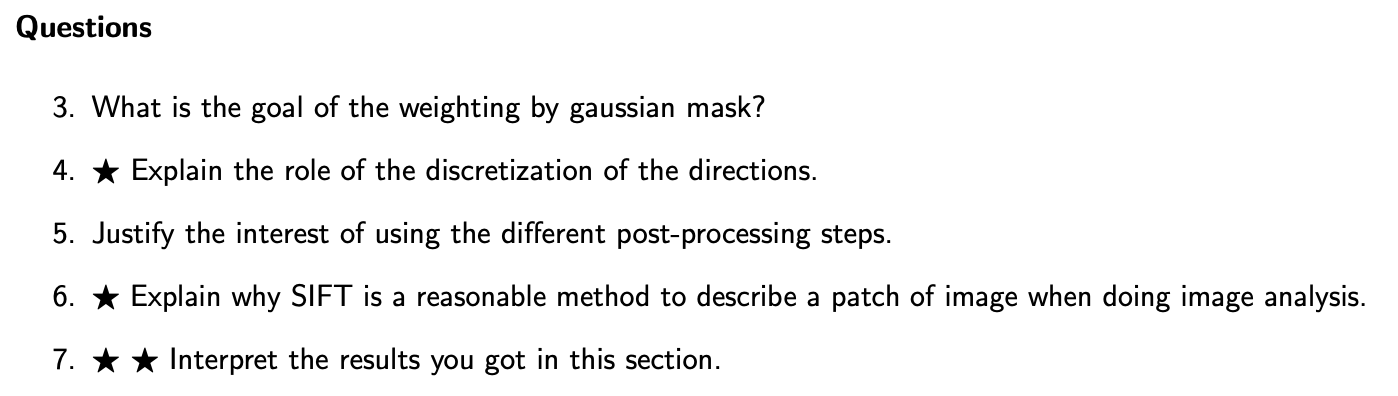

3) la partie masque gaussien permet de donner de l'importance au centre de l'image. Il agit comme un filtre d'attention
4) Les orientations continues (0°–360°) sont projetées dans 8 bins (0°, 45°, …, 315°) -> permet de résumer les orientations de manière compacte et robuste : un léger changement d’angle (ex. 44° → 46°) ne change pas radicalement le bin.
Cela rend le descripteur tolérant au bruit et permet de comparer efficacement les patches entre eux.
5) permet de gérer les valeurs extrêmes en les mettant à 0.2 et d'être invariant à la luminosité, rotation... + tous les patch sont mis à la même échelle -> comparables
6) Avec les étapes de post processing du Pencodeur, l'image devient invariante à la luminosité et a la rotation. Ce qui fait de SIFT une méthode robuste + encode l'information de manière comapcte (128 valeurs)
7) Pour un patch avec un bord diagonal (ex. sur la pince), le descripteur a des pics dans les bins correspondant aux orientations diagonales → il encode bien la présence d’un contour oblique. Pour un patch avec un coin noir/blanc, le descripteur a des pics dans les bins verticaux/horizontaux → il encode bien la présence de deux directions fortes (coin). Globalement, les résultats montrent que SIFT traduit correctement les structures géométriques locales (bords, coins, contours) en vecteurs numériques stables.

# Compute SIFT

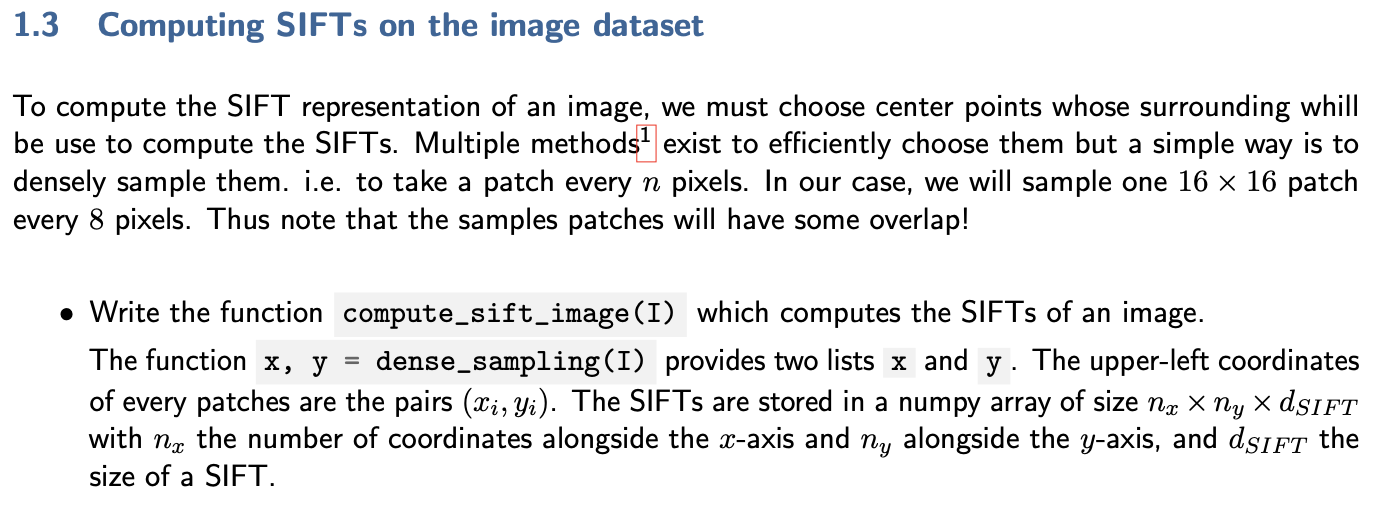

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()

    # Ici, effectuez les calculs sur l'image globale (norme, gradients)
    Gn, Go = compute_grad_mod_ori(im)

    k = 16
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):

            g_m_r = Gn[xi:xi+k, yj:yj+k]
            g_o_r = Go[xi:xi+k, yj:yj+k]
            sifts[i,j] = compute_sift_region(g_m_r, g_o_r, mask=m)

    return sifts



The computation may last several minutes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
max_images_per_class = 10  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs
1/150
2/150
3/150
4/150
5/150
6/150
7/150
8/150
9/150
10/150
11/150
12/150
13/150
14/150
15/150
16/150
17/150
18/150
19/150
20/150
21/150
22/150
23/150
24/150
25/150
26/150
27/150
28/150
29/150
30/150
31/150
32/150
33/150
34/150
35/150
36/150
37/150
38/150
39/150
40/150
41/150
42/150
43/150
44/150
45/150
46/150
47/150
48/150
49/150
50/150
51/150
52/150
53/150
54/150
55/150
56/150
57/150
58/150
59/150
60/150
61/150
62/150
63/150
64/150
65/150
66/150
67/150
68/150
69/150
70/150
71/150
72/150
73/150
74/150
75/150
76/150
77/150
78/150
79/150
80/150
81/150
82/150
83/150
84/150
85/150
86/150
87/150
88/150
89/150
90/150
91/150
92/150
93/150
94/150
95/150
96/150
97/150
98/150
99/150
100/150
101/150
102/150
103/150
104/150
105/150
106/150
107/150
108/150
109/150
110/150
111/150
112/150
113/150
114/150
115/150
116/150
117/150
118/150
119/150
120/150
121/150
122/150
123/150
124/150
125/150
126/150
127/150
128/150
129/150
130/150
131/150
132/150
133/150
134/150
135/150
1

In [ ]:
sifts_list_by_image[0].shape

(28, 42, 128)

# Part II: Visual Dictionary

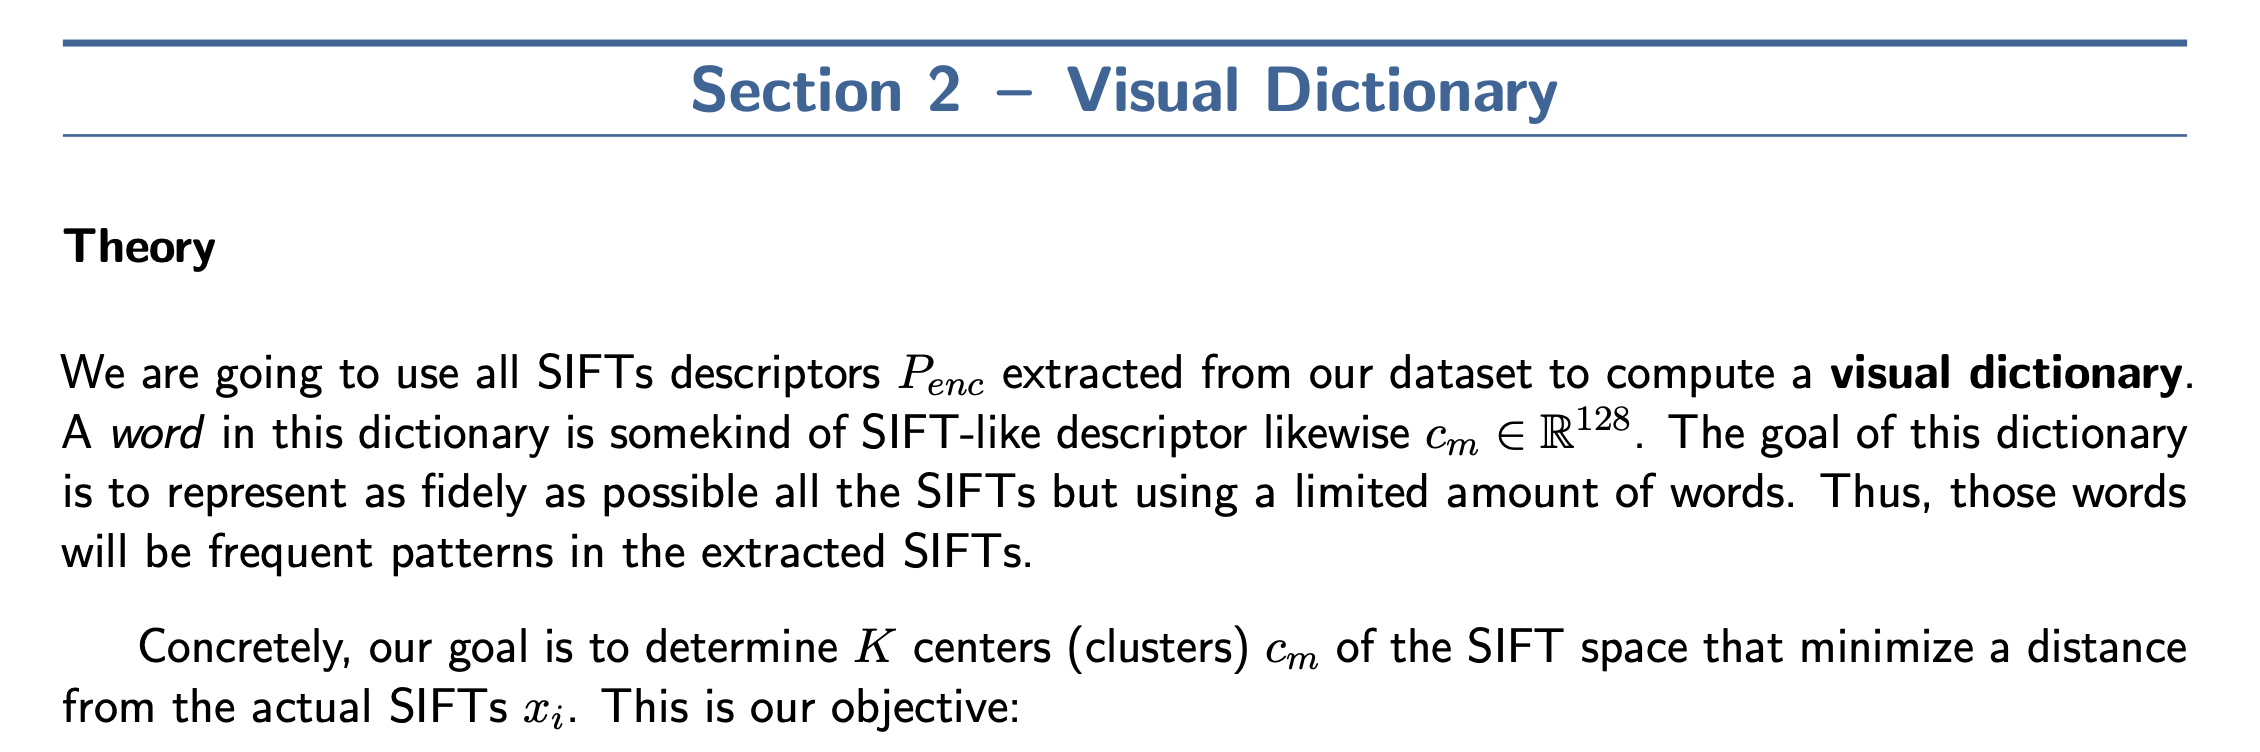

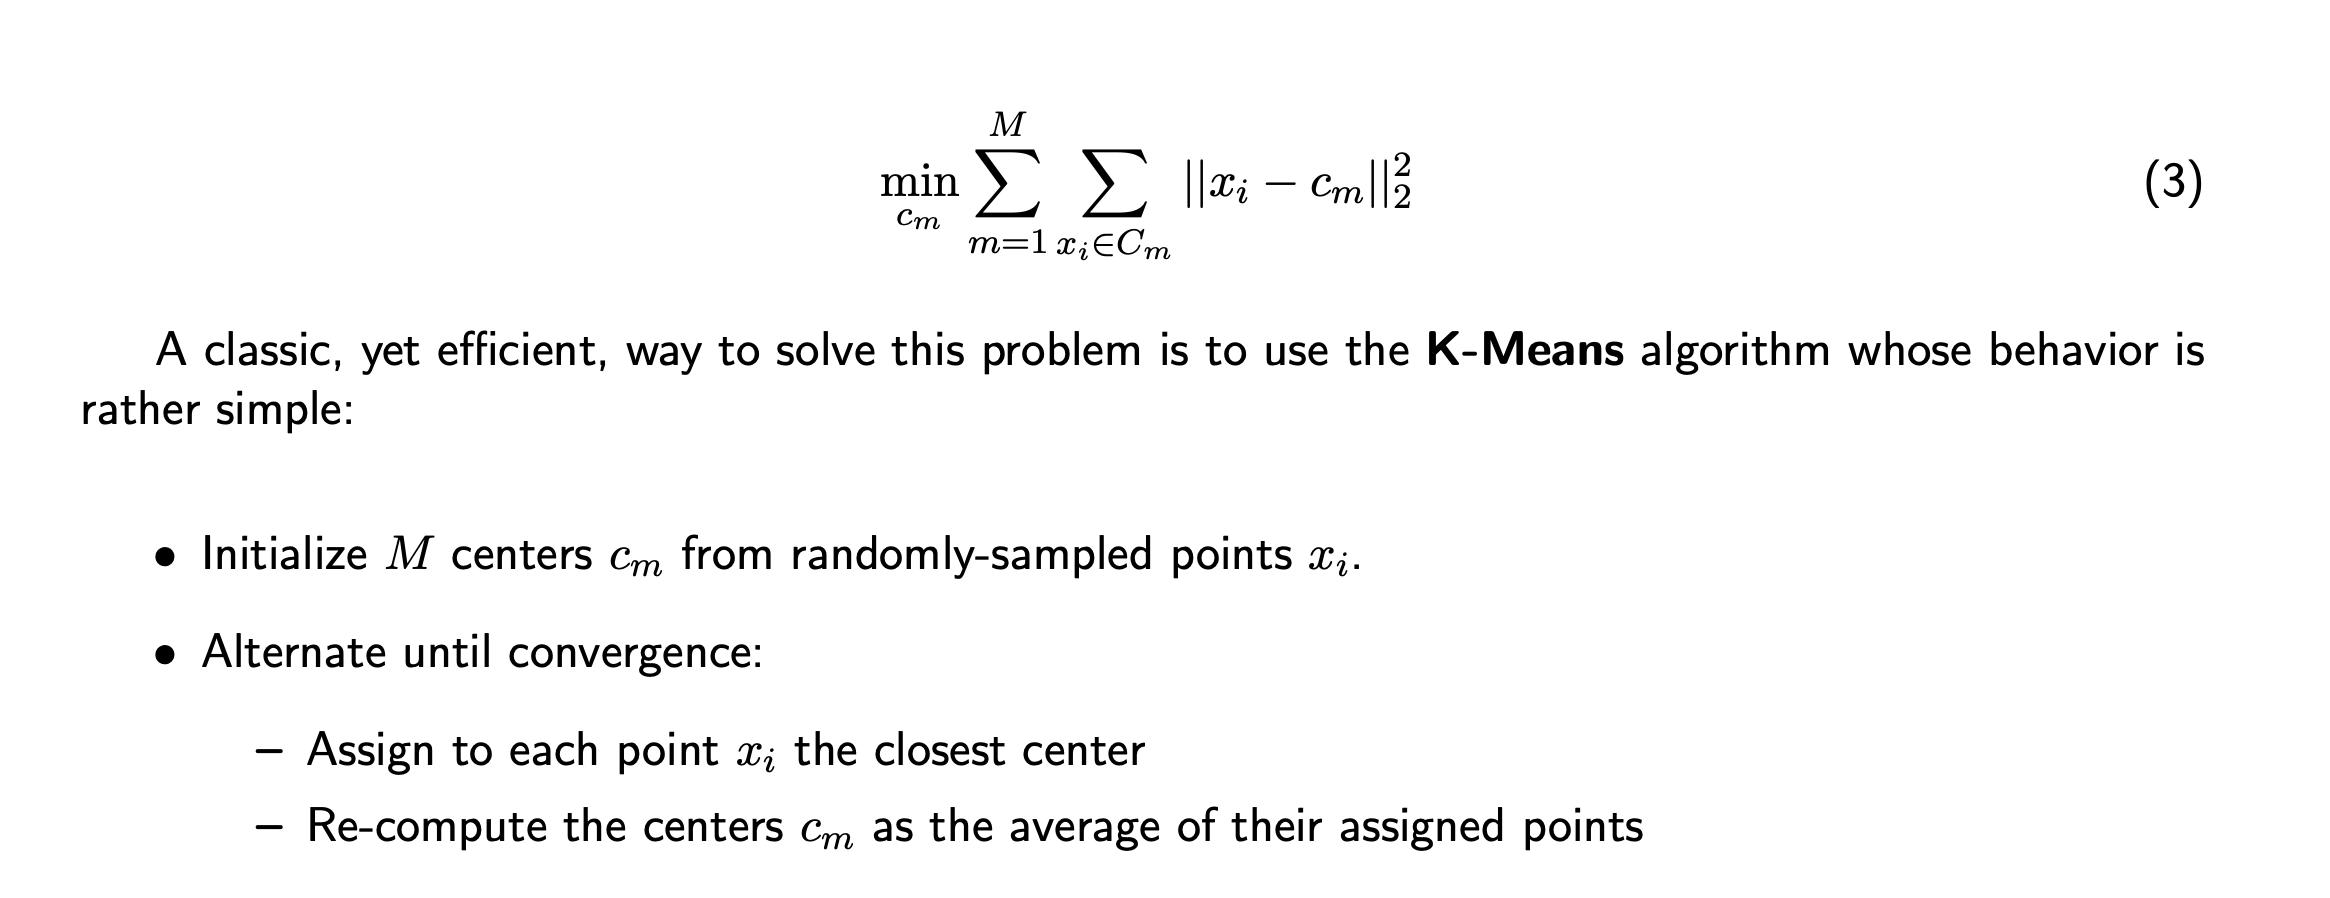

In [ ]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [ ]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    # Chaque image fournit un ensemble de descripteurs SIFT (128 dimensions)
    dim_sift = sift[0].shape[-1]
    # applatissement en une matrice Nx128 qui contient tous les descripteur sift
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    # On enlève les vecteurs nuls (qui correspondent à des patches sans structure).
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    # Pour ne pas faire tourner kmeans longtemps on prend un échantillon (ici 5%)
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    print("shape sifts:", sift.shape)

    # Compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict
    # modele Kmeans

    kmeans = KMeans(
        n_clusters=n_clusters,
        verbose=verbose,
        n_init=n_init,
        max_iter=10,
       # n_jobs=3
    )
    kmeans.fit(sift)
    # vdict contient els centres des clusters
    vdict = kmeans.cluster_centers_
    # ajoute un mot visuels nuls ?
    vdict = np.append(vdict, np.zeros((1, dim_sift)), axis=0)
    return vdict


In [ ]:
# Run the visual dict computation (saved the first time)
# from tools import compute_vdict

vdict = compute_visual_dict(sifts_list_by_image)
#vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

shape sifts: (7780, 128)
Initialization complete
Iteration 0, inertia 218111593.0.
Iteration 1, inertia 147522793.8806107.
Iteration 2, inertia 146023786.44703358.
Iteration 3, inertia 145549701.13652018.
Iteration 4, inertia 145395245.9726015.
Iteration 5, inertia 145348125.04173154.
Iteration 6, inertia 145316435.75712186.
Iteration 7, inertia 145299842.65879568.
Iteration 8, inertia 145286742.8115861.
Converged at iteration 8: strict convergence.


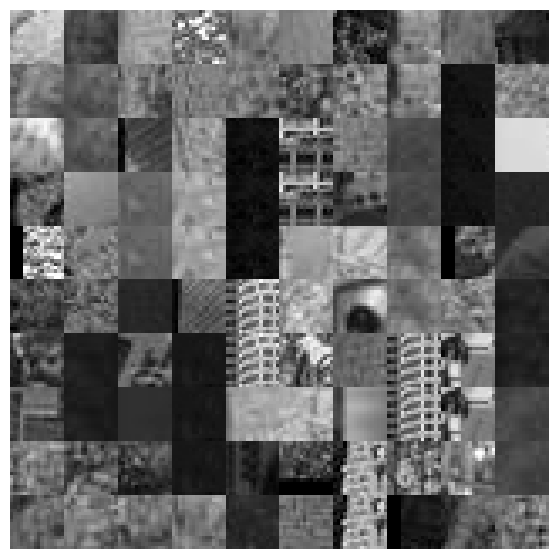

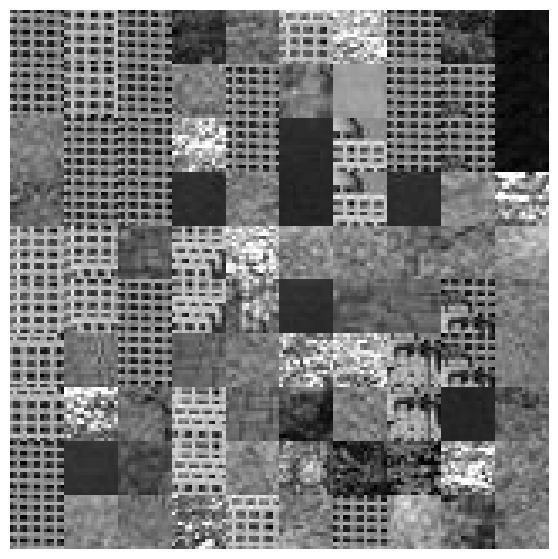

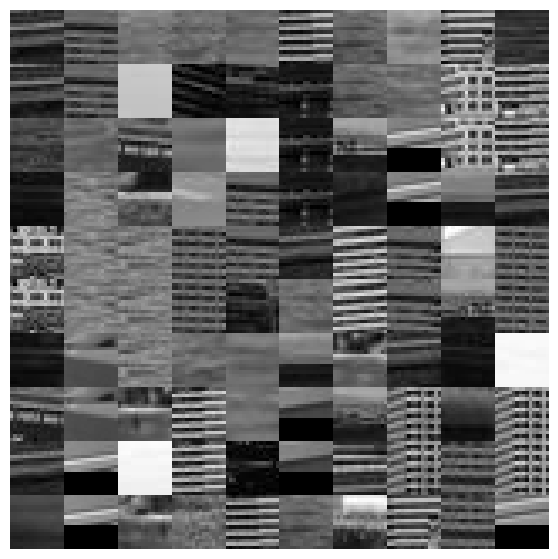

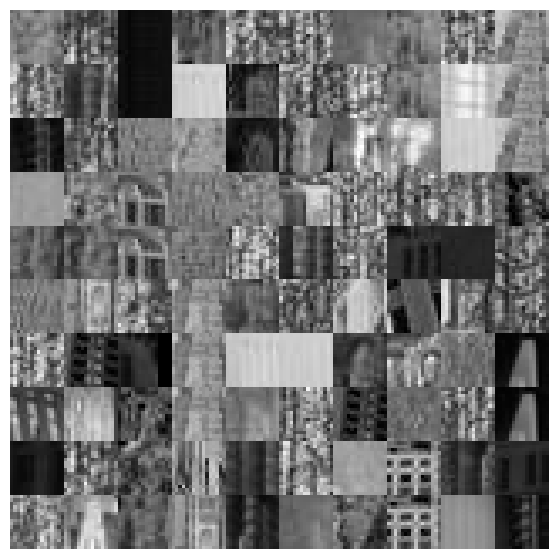

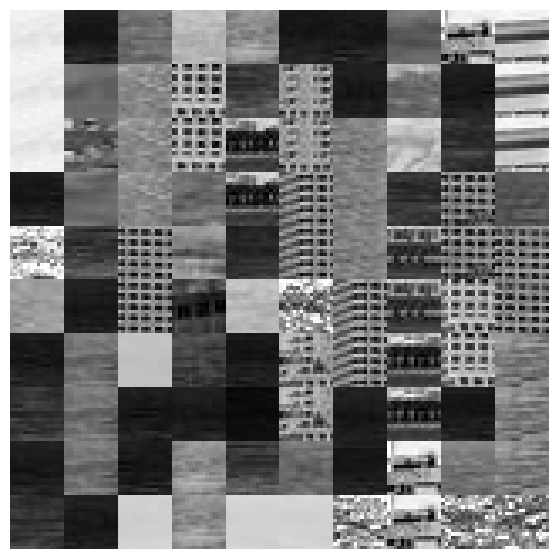

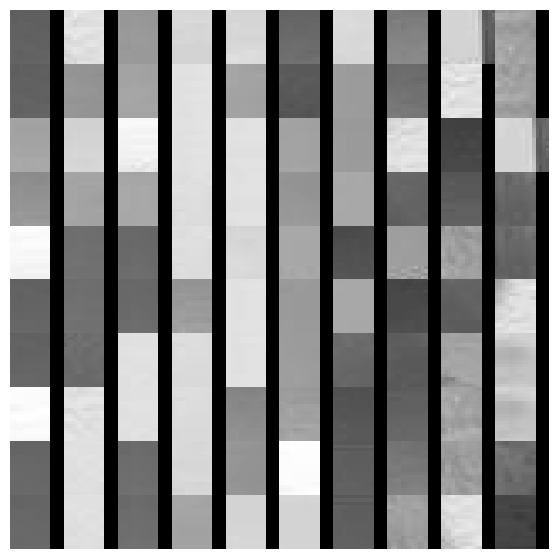

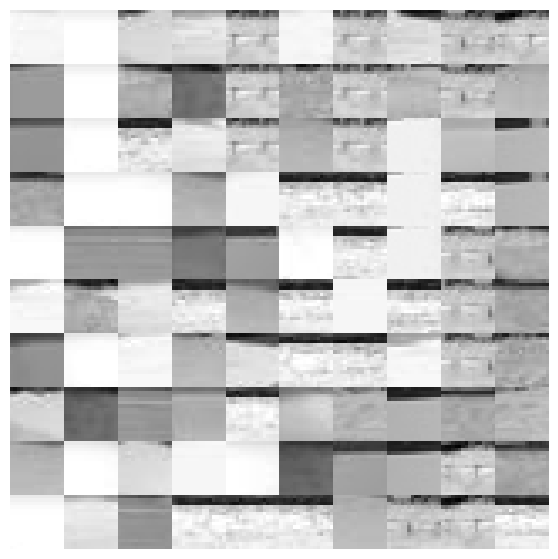

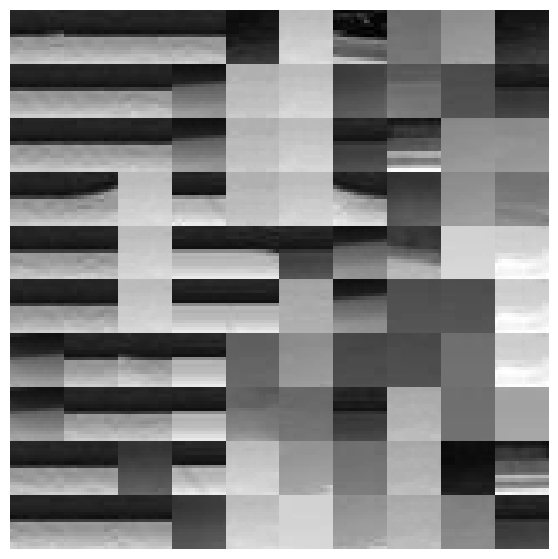

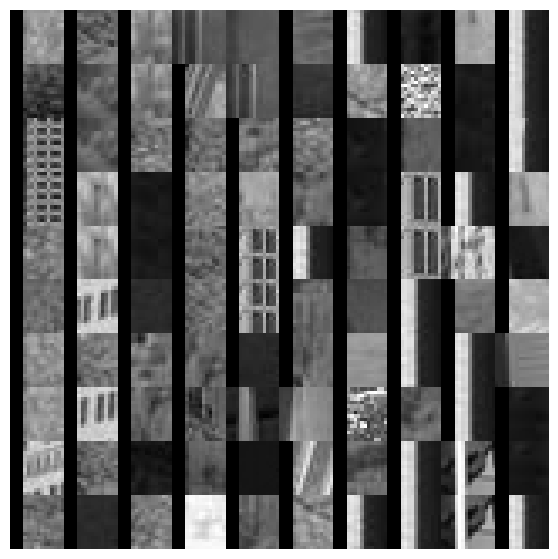

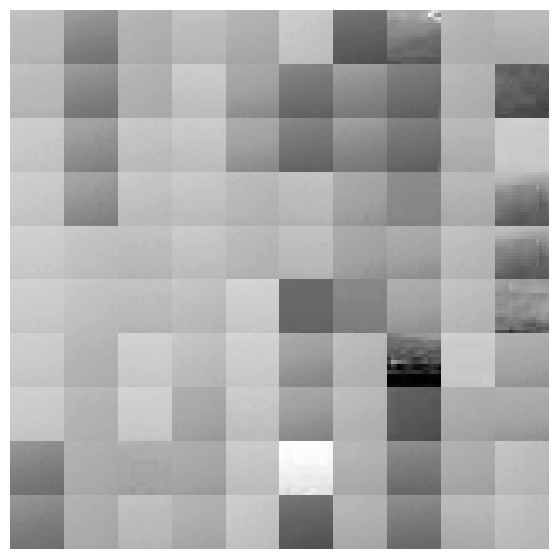

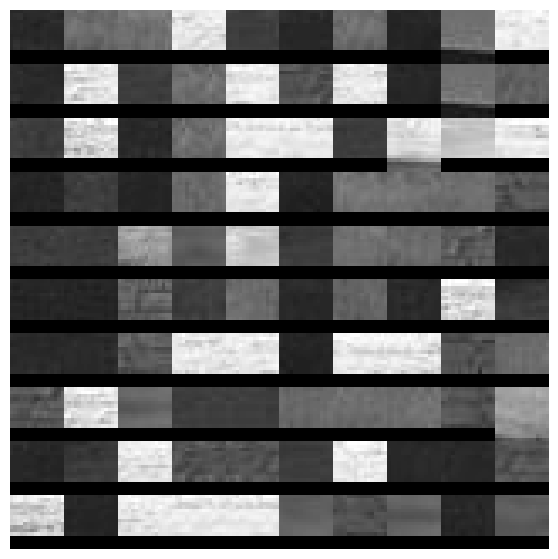

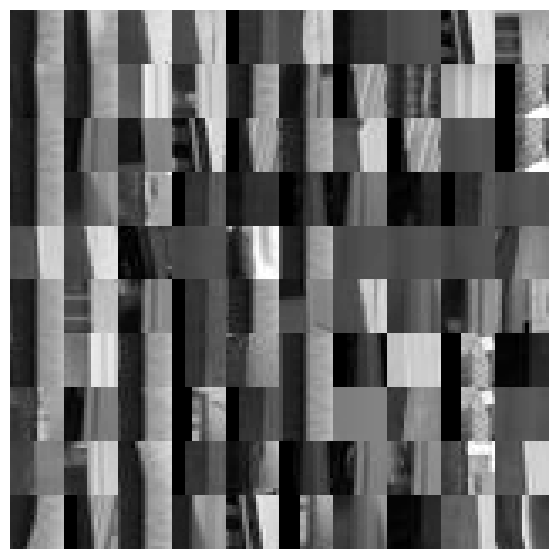

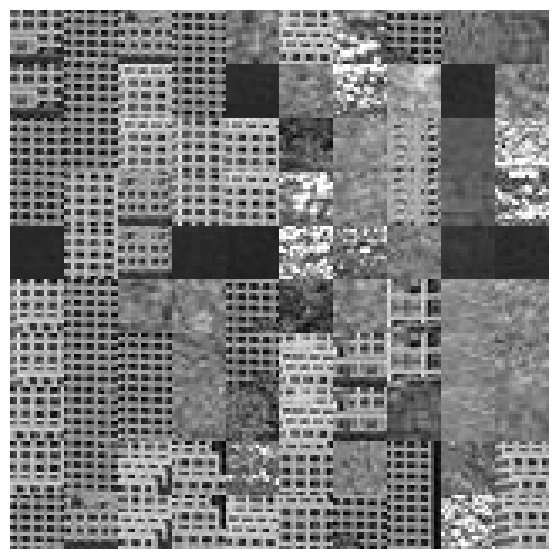

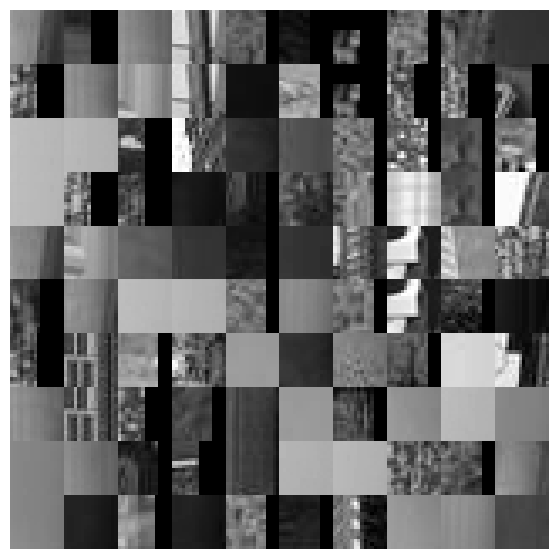

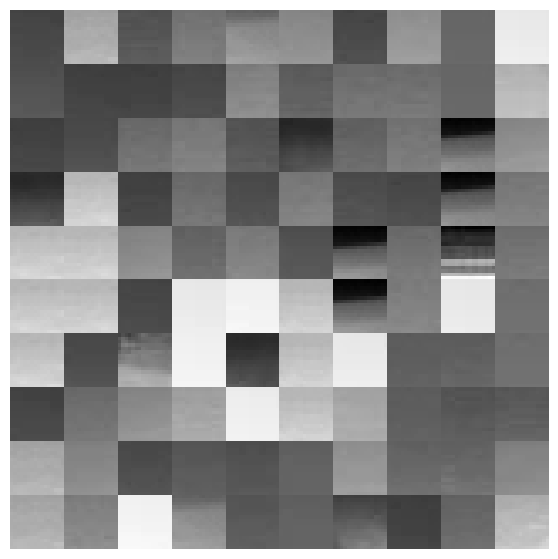

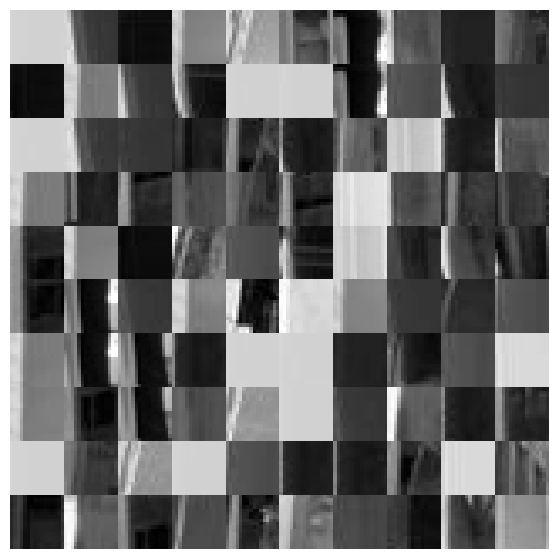

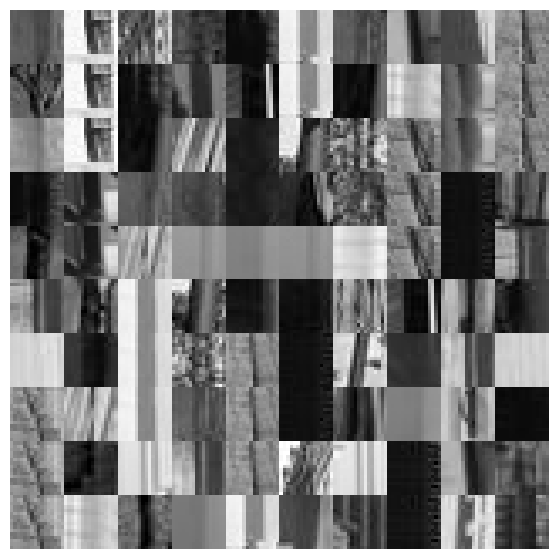

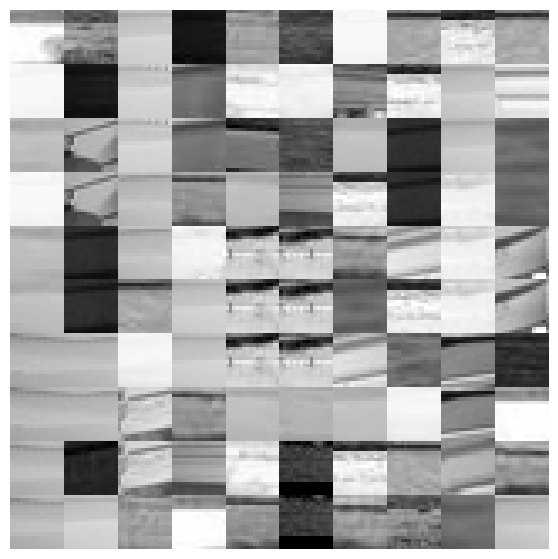

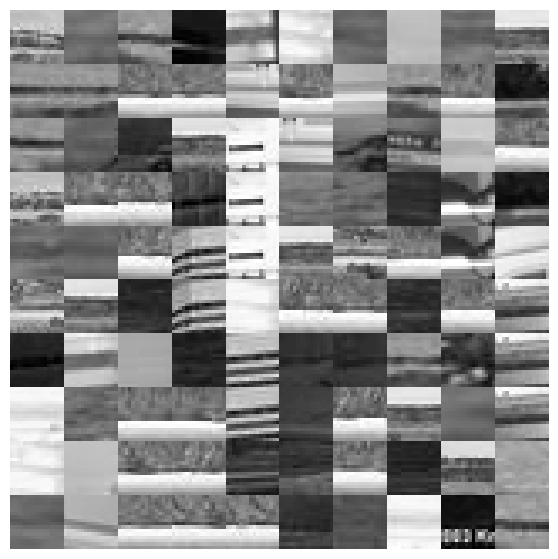

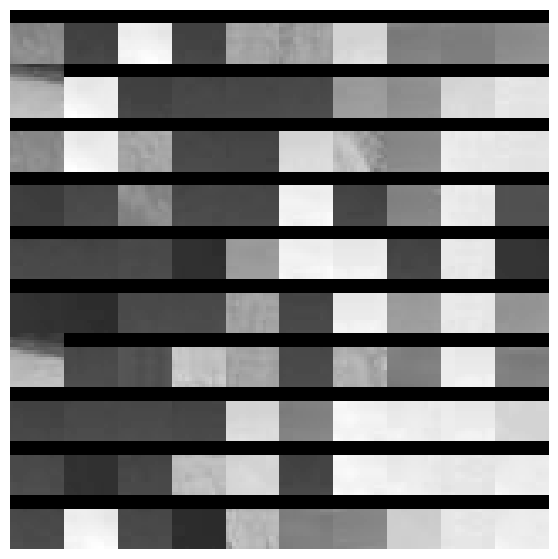

In [ ]:
# Study of the dict

# choose random images dans le dataset
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

# Extraction des patches et des SIFT associés
regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
# display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# 20 premiers centres du dictionnaire (donc 20 “mots visuels”).
centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  # on calcule la distance avec les descripteurs sifts (sont de même taille)
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100 on garde les 100 patch les plus proches de ce centre
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

-> Ces patches sont ceux dont le descripteur SIFT est le plus proche d’un mot visuel particulier

-> regoupé par motif locaux similaires

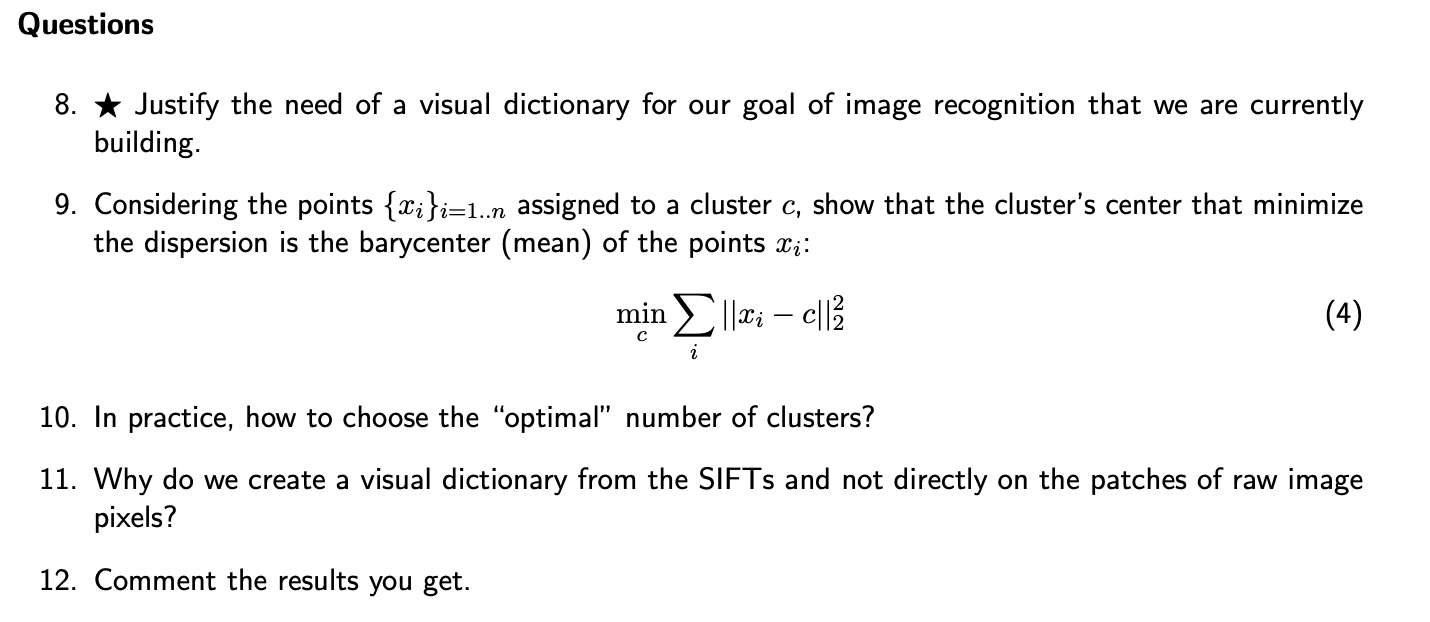

8) Un dataset réel contient des millions de SIFT (vecteurs 128D). Travailler avec tous est coûteux et redondant. On regroupe ces vecteurs en mots visuels (centres clusters) k-means. Chaque image est alors décrite par un histogramme de fréquences des mots (Bag of Visual Words, BoW) :

9) fait
10) Choisir le K par validation croisée ? ou technique du coude
11) Les SIFT encapsulent les gradients locaux (orientation + pondération) → invariance (ou quasi) à éclairage/contraste, petite translation, rotation locale. Les SIFT sont plus compacts et informés (128D) que des patches bruts 16x16 = 256 sans normalisation ni invariances.
12)

# Part III: BoW

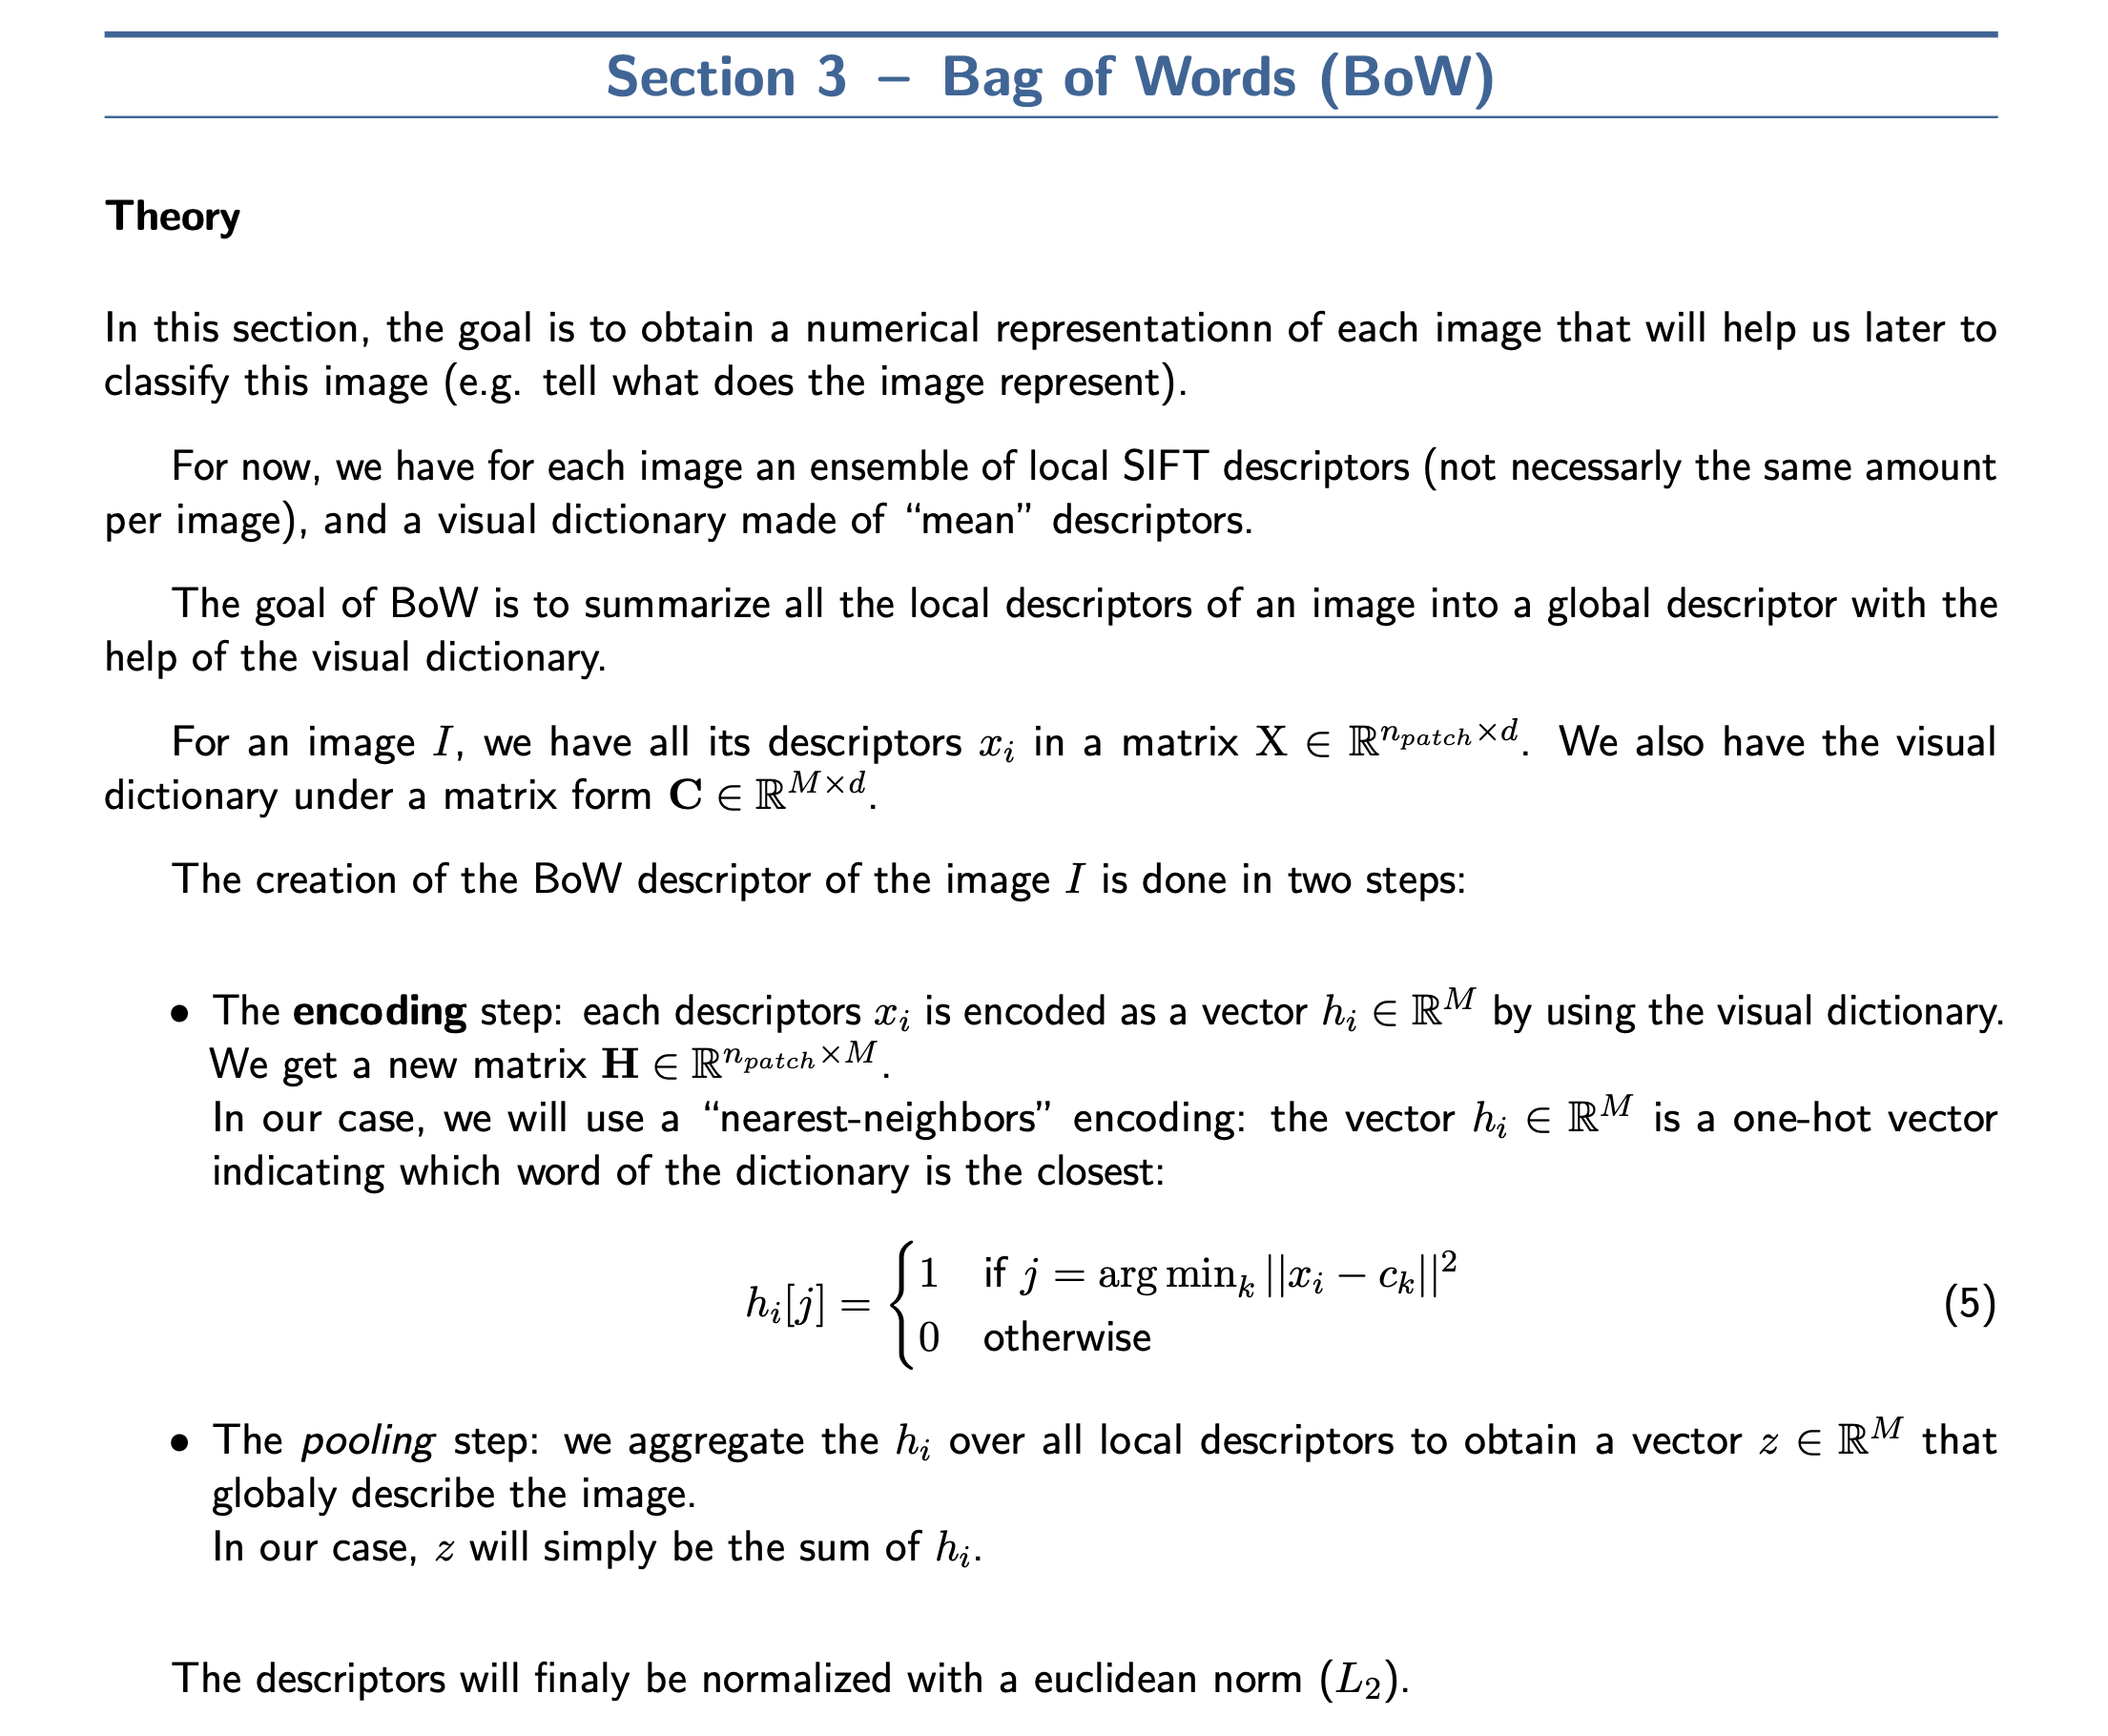

In [ ]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])
    print(sifts.shape[0], feats.shape[0])

    # compute distance from image sifts to vdict
    dist = euclidean_distances(vdict, sifts)
    print(dist.shape)
    descriptor = (dist == dist.min(axis=0)[None,:]).astype(int).sum(axis=1)
    #print(descriptor.shape)
    #print(descriptor)

    #print(descriptor)

    return descriptor

1176 1001
(1001, 1176)


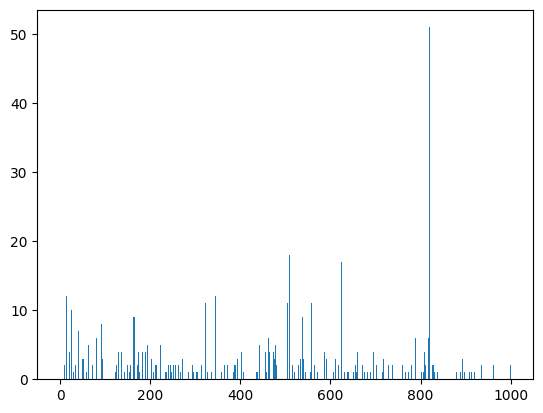

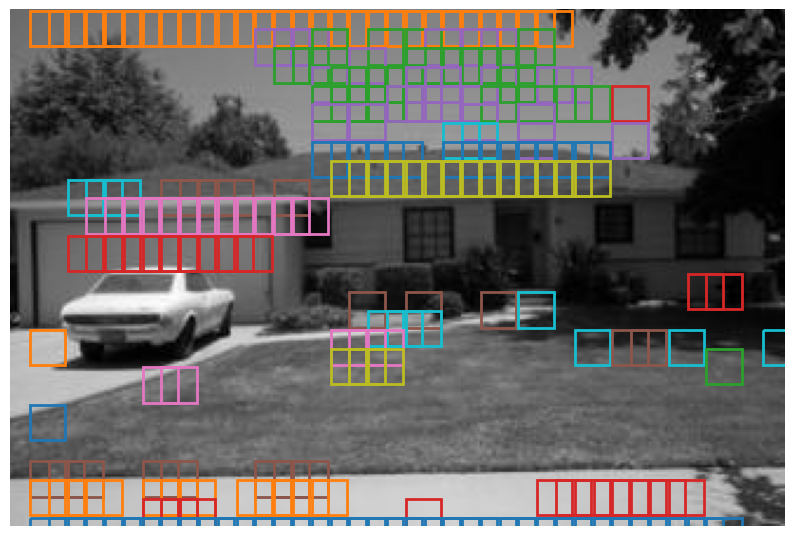

(9, 16, 16)


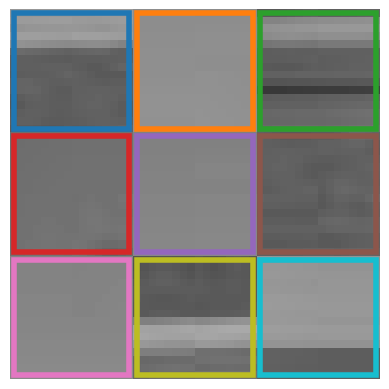

In [ ]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here

* Histogramme (première image)
  * Axe horizontal = les mots visuels (0 à 1000, si dictionnaire de taille 1000).
  * Axe vertical = la fréquence de chaque mot visuel dans cette image.
  * On voit un pic très fort autour du mot ~820 → cela veut dire que dans cette image, beaucoup de patches sont proches de ce mot visuel particulier (probablement une texture dominante, comme des bords horizontaux).

* Deuxième image
  * Chaque carré coloré = un patch (16×16) où un SIFT a été extrait.
  * La couleur = le mot visuel auquel ce patch a été assigné (le cluster le plus proche).

* Troisème image
  * Chaque carré coloré est une visualisation du centre de cluster (le mot visuel).
  * Ces patches moyens représentent des motifs typiques appris dans le dataset

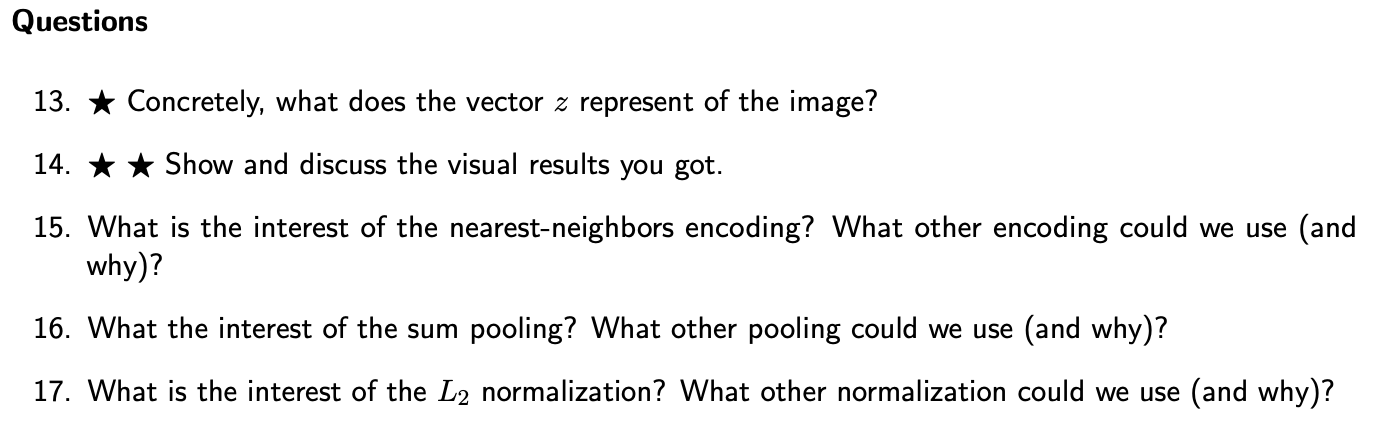

13) Le vecteur z est un histogramme de mots visuels.Chaque dimension correspond à un mot visuel du dictionnaire. La valeur z[j] = combien de descripteurs SIFT de l’image ont été assignés au mot visuel cj

14) Les patches colorés montrent où apparaissent les mots visuels dans l’image.Les patches moyens illustrent les prototypes appris (bords horizontaux, coins, textures homogènes). L’histogramme BoW montre la répartition des mots visuels
16) c'est pour compter combien de fois chque mot visuel apparait dans l'image
17) permet de rendre comparable et de pas faire exeploser les valeurs

# Part IV: SVM

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

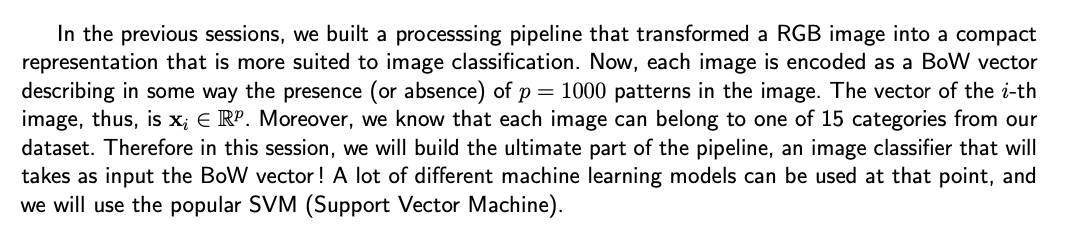

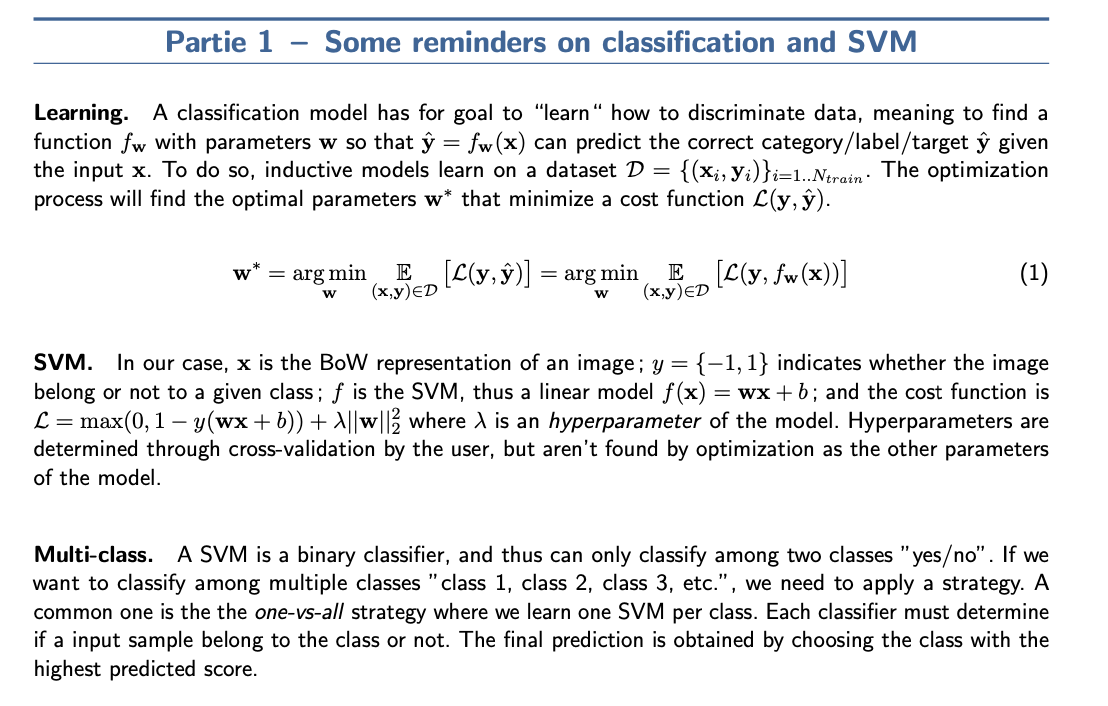

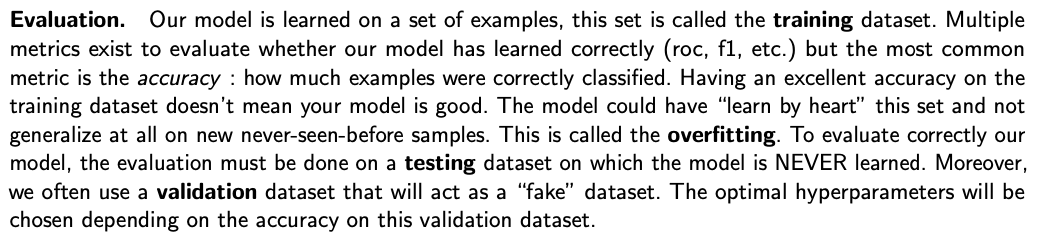

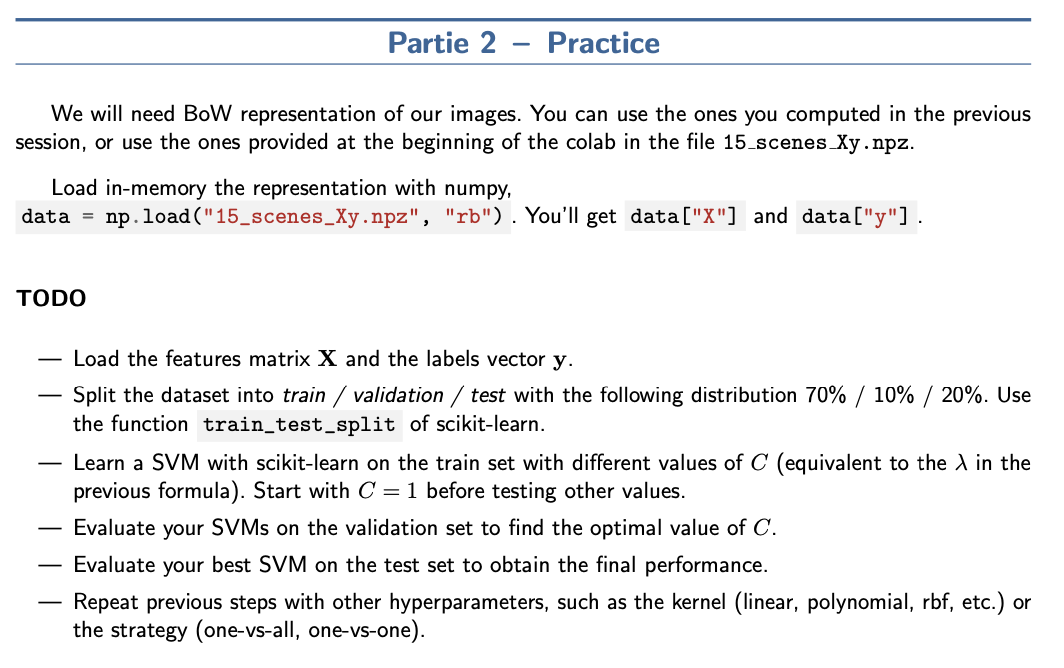

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/15_scenes_Xy.npz

--2025-09-27 13:22:23--  https://github.com/rdfia/rdfia.github.io/raw/master/data/15_scenes_Xy.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/15_scenes_Xy.npz [following]
--2025-09-27 13:22:24--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/15_scenes_Xy.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35952210 (34M) [application/octet-stream]
Saving to: ‘15_scenes_Xy.npz’

15_scenes_Xy.npz    100%[===================>]  34.29M   227MB/s    in 0.2s    

2025-09-27 13:22:24 (227 MB/s) - ‘15_scenes_Xy.npz’ saved [35952210/35952210]



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split

Loading BoW of the whole dataset (4485 images, thus 4485 dictionnary of 1001 words):

In [ ]:
data = np.load("15_scenes_Xy.npz")
data
# clé X -> images
#

NpzFile '15_scenes_Xy.npz' with keys: X, y

In [ ]:
data = np.load("15_scenes_Xy.npz")
#TODO
X = data['X']
#TODO
y = data['y']

X.shape, y.shape

((4485, 1001), (4485,))

In [ ]:
X,y

(array([[  1,   2,   0, ...,   2,   3, 236],
        [  0,   0,   0, ...,   0,   0, 643],
        [  1,   0,   0, ...,   0,   2, 127],
        ...,
        [  1,   2,   0, ...,   0,   1,  94],
        [  0,   1,   0, ...,   0,   0, 545],
        [  0,   0,   0, ...,   1,   0, 180]]),
 array([ 6,  6,  5, ...,  6, 13,  6]))

In [ ]:
min(y)

np.int64(0)

Let's see what is the class distribution:

In [ ]:
{c: nb for c, nb in enumerate(np.bincount(y))}

{0: np.int64(241),
 1: np.int64(360),
 2: np.int64(328),
 3: np.int64(260),
 4: np.int64(308),
 5: np.int64(374),
 6: np.int64(410),
 7: np.int64(292),
 8: np.int64(356),
 9: np.int64(215),
 10: np.int64(216),
 11: np.int64(311),
 12: np.int64(210),
 13: np.int64(289),
 14: np.int64(315)}

Split the dataset into a train & test set:

In [ ]:
#TODO

# d'abord, on commence par train (70%) et temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)


Then a validation set from the train set:

In [ ]:
#TODO

# puis on découpe X_temp pour que : val (10%) et test (20%)
# val = 1/3 de X_temp = 10% du total
# test = 2/3 de X_temp = 20% du total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (3139, 1001) (3139,)
Val: (448, 1001) (448,)
Test: (898, 1001) (898,)


Let's KFold over different values of `C`:

In [ ]:
from sklearn.svm import SVC

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]  # paramètre de régularisation
accuracies = []

for c in C_values:
  print(f'Training SVM with C={c}')
  #TODO

  clf = SVC(C = c, decision_function_shape='ovr')

  # Fit on sub-train set
  clf.fit(X_train, y_train)

  # Evaluate on val set
  acc = clf.score(X_val, y_val)
  #y_pred_val = clf.predict(X_val)
  #acc = np.mean(y_pred_val == y_val)

  accuracies.append(acc)
  print(f'--> accuracy = {acc}')

# choisir le meilleur C
best_idx = np.argmax(accuracies)
best_C = C_values[best_idx]
best_acc = accuracies[best_idx]
print(f"Best C on val: {best_C} (acc={best_acc:.4f})")

Training SVM with C=0.01
--> accuracy = 0.17410714285714285
Training SVM with C=0.1
--> accuracy = 0.27232142857142855
Training SVM with C=1
--> accuracy = 0.5178571428571429
Training SVM with C=10
--> accuracy = 0.7120535714285714
Training SVM with C=100
--> accuracy = 0.7388392857142857
Best C on val: 100 (acc=0.7388)


Text(0.5, 1.0, "Précision en fonction de l'ajustement de la régularisation")

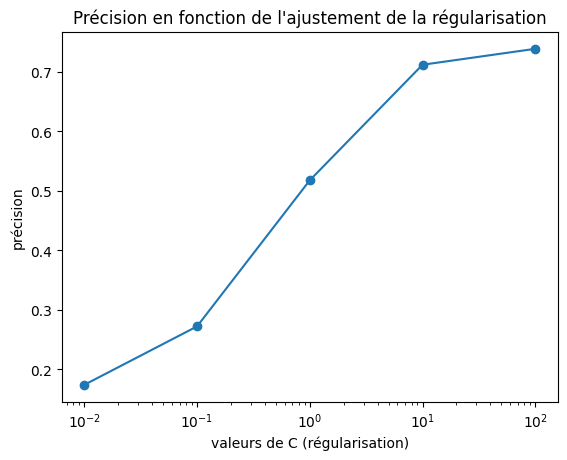

In [ ]:
#TODO plot the relation between `c` and the accuracy

accuracies

ax, fig = plt.subplots()
fig.plot(C_values, accuracies, marker = 'o')
fig.set_xlabel("valeurs de C (régularisation)")
fig.set_ylabel("précision")
fig.set_xscale("log")
fig.set_title("Précision en fonction de l'ajustement de la régularisation")

In [ ]:
#TODO Fit on the whole train set, evaluate on the test set
clf = SVC(C = 100, decision_function_shape='ovr')
clf.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
test_acc = clf.score(X_test, y_test)
print(f"Final test accuracy = {test_acc:.3f}")

Final test accuracy = 0.768


Do the same with different kernel values, and different decision functions:

In [ ]:
# TODO

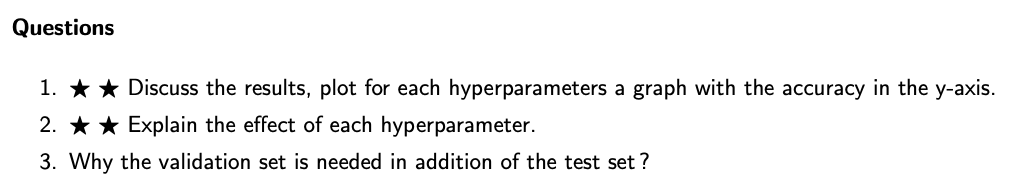

1) C trop petit -> sous apprentissage mais C trop grand -> sur apprentissage
2) C paramètre de régularisation controle biais/variance
Kernel : détermine la fonction de séparation dans l’espace des features
One-vs-one : plus coûteux (beaucoup de classifieurs), mais parfois meilleure précision si les classes sont très proches
3) Le validation set sert à choisir les hyperparamètres (par ex. le meilleur C, le bon noyau) Le test set doit être gardé totalement séparé → il ne sert qu’à évaluer la performance finale après tous les choix.